# Notes to self

# Imports

In [1]:
%run 'psd_mc_functions.ipynb'

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

Reading XAMS data from pickles...
Read data in 23.01 seconds


In [2]:
import pandas as pd
from tqdm import tqdm
import re
from time import sleep
from matplotlib import gridspec

In [3]:
# data_dir = '/data/xenon/ehogenbi/pulsefit/processing_pickles'
data_dir = '/home/erik/win/BCK/pulsefit_pickles_180206/'

# Functions

## Reading

In [4]:
def read_pickles(dirname, base_name, max_i = None):
    if max_i is None:
        fns = os.listdir(dirname)
        fns = [os.path.join(dirname, fn) for fn in fns if re.match(base_name + '_....pickle', fn)]#if base_name in fn]
        fns = np.sort(fns)
    else:
        fns = [os.path.join(dirname, base_name + '_%03d.pickle' % i) for i in range(max_i)]
    if len(fns) == 0:
        print('Found no filenames for base %s, skipping...' % base_name)
        return pd.DataFrame([])
    dicts = []
    for fn in fns:
        with open(fn, 'rb') as f:
            current_dict = pickle.load(f)
            dicts.append(current_dict)
            if 'chi2' not in current_dict[0].keys():
                print('Warning: found no chi2 in file %s' % fn)
    dicts =  np.concatenate(dicts)
    
    df = pd.DataFrame(list(dicts))
    if df.isnull().values.any():
        print('Warning: found some NaNs or Nones in the dataframe. Maybe check your computation results?')
    if 'chi2' not in df.keys():
        print('Warning: found no chi2 for %s. Are you reading unprocessed files?' % (base_name))
    print('Read %d datapoints from %d files.' % (len(df), len(fns)))
    if 'stored_stat' in df.keys():
        # Brainfart when I put this in
        df['stored_stat_value'] = df['stored_stat']
        df['stored_stat'] = True
    return df



In [5]:
def round_df(df, decimals = 3):
    '''Round all non-str values of the dataframe to string ones.'''
    for key in df.keys():
        if type(df[key].iloc[0]) == str:
            continue
        df[key] = np.round(df[key], decimals)
    return df

def round_ddf(ddf, keys = ['fs', 't3', 't1', 'tts'], decimals = 3):
    '''
    Round the values of certain keys to a few decimals.
    This prevents plotting artifacts.
    '''
    ddf_new = []
    for df in ddf:
        for key in keys:
            df[key] = np.round(df[key], decimals=decimals)
        ddf_new.append(df)
    return ddf_new

def remove_common(df1, df2, key_list = ['dset', 't3', 't1', 'fs', 'tts']):
    '''
    Remove all the elements in df1 that are already in df2 (comparing the keys in key_list)
    '''
    df1_sub = deepcopy(df1[key_list])
    df2_sub = deepcopy(df2[key_list])
    df1_sub = round_df(df1_sub)
    df2_sub = round_df(df2_sub)
    mask = np.invert(pd.concat([df1_sub,df2_sub]).duplicated(keep=False).values[:len(df1_sub)])
    print('Removing %d of %d items, already exist...' % (sum(np.invert(mask)), len(df1)))
    df1 = df1[mask]
    df1 = df1.reset_index(drop=True)
    return df1

In [6]:
def read_and_combine(dirname, list_of_base, remove_duplicates = True, key_list = ['dset', 't3', 't1', 'fs', 'tts']):
    '''
    Read dataframes with different base_name, merge dataframes and remove duplicates.
    '''
    df_list = []
    for base_name in list_of_base:
        df_list.append(read_pickles(dirname, base_name))
    df = pd.concat(df_list)
    df_keys = deepcopy(df[key_list])
    df_keys = round_df(df_keys)
    mask = np.invert(df_keys.duplicated().values)
    if sum(np.invert(mask)) > 0:
        print('Removing %d of %d items, already exist...' % (sum(np.invert(mask)), len(df)))
    # Reset the index after concatenating
    df = df.reset_index(drop=True)
    return df

In [7]:
def read_energy_bins(data_dir, base_name, e_bins):
    '''
    Read all datasets.
    Returns list of dataframes
    '''
    ddf = []
    for e_min, e_max in zip(e_bins[:-1], e_bins[1:]):
        df = read_pickles(data_dir, base_name + '_%02d_%02d' % (e_min, e_max))
        ddf.append(df)
    return ddf

In [8]:
def read_and_combine_energy_bins(data_dir, base_names, e_bins):
    ddf = []
    ddf = []
    for e_min, e_max in zip(e_bins[:-1], e_bins[1:]):
        df = read_and_combine(data_dir, [base_name + '_%02d_%02d' % (e_min, e_max) for base_name in base_names])
        ddf.append(df)
    return ddf

## Plotting

In [9]:
def parslice_2d(df, x, y, key = 'chi2', plot_min = True, vmax=None, noshow=False, **kwargs):
    '''
    Plot the minimum values of chi2 for two variables (i.e. a projection of the minimum onto the 2d slice)
    '''
    dfmin = df.sort_values(by=key).iloc[0]
    if vmax is None:
        vmax = dfmin['chi2'] * 1.5
    grouped = df.groupby(by = (x, y)).min()
    grouped[x] = grouped.index.get_level_values(x)
    grouped[y] = grouped.index.get_level_values(y)
    plt.scatter(grouped[x], grouped[y], c= grouped[key], vmax = vmax, **kwargs)
    plt.colorbar(label='chi2/ndf')
    if plot_min:
        plt.scatter(dfmin[x], dfmin[y], color='red', marker='+', s = 500)

    plt.xlabel(x)
    plt.ylabel(y)
    if not noshow:
        plt.show()

In [10]:
def parslice_2d_values(df, x, y, key = 'chi2'):
    '''
    Give x, y, and z
    '''
    dfmin = df.sort_values(by=key).iloc[0]
    grouped = df.groupby(by = (x, y)).min()
    grouped[x] = grouped.index.get_level_values(x)
    grouped[y] = grouped.index.get_level_values(y)
    return grouped[x], grouped[y], grouped[key]

In [11]:
def plot_all_slices(df, vmax = None, key='chi2', **kwargs):
    '''
    Inspect the 2d slices to find the minimum.
    '''
    if vmax is None:
        vmax = np.min(df[key] * 1.5 )
    for x, y in zip(['t3', 't1', 't1'], ['fs', 'tts', 't3']):
        parslice_2d(df, x, y,key=key, vmax = vmax,  **kwargs)
    return

In [12]:
def plot_all_slices_rec(df, vmax = None, key='chi2', **kwargs):
    '''
    Inspect the 2d slices to find the minimum.
    '''
    if vmax is None:
        vmax = np.min(df[key] * 1.5 )
    for x, y in zip(['eta', 'eta', 'eta'], ['tr', 'fs_r', 'f_r']):
        parslice_2d(df, x, y,key=key, vmax = vmax,  **kwargs)
    return

In [13]:
def plot_all_slices_killed(df, tts=1.5, vmax=None, key='chi2', **kwargs):
    '''
    Inspect the 2d slices for tts fixed
    '''
    _df = kill_tts(df, tts=tts)
    for x, y in zip(['t3', 't3', 'fs'], ['fs', 't1', 't1']):
        parslice_2d(_df, x, y,key=key, vmax = vmax,  **kwargs)
    return

In [14]:
def plot_slice_containing_point(df, x, y, row, **kwargs):
    df_sel = deepcopy(df)
    for key in row.keys():
        if (key == x) or (key == y) or (key=='chi2'):
            continue
        df_sel = df_sel[df_sel[key] == row[key]]
    plt.scatter(df_sel[x], df_sel[y], c= df_sel['chi2'], **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(label='chi2/ndf')
    plt.show()

## Minimum stability

In [15]:
def get_some_minima(df, n_values=None, threshold=None, key='chi2'):
    '''
    Get the minimum n points of the dataframe up to chi2 value specified by threshold.
    If threshold is None, just take n values.
    If n_values is None, no restriction on the number of points.
    This function may be used to get the statistical error, although perhaps tricky how.
    Maximum deviation? std? 
    '''
    if n_values is None:
        selected_minima = df.sort_values(by = key)
    else:
        selected_minima = df.sort_values(by = key)[:n_values]
    if threshold is not None:
        selected_minima = selected_minima[selected_minima[key] <= threshold]
    print('Selected %d values with %s ranging from %.2f to %.2f...' % (len(selected_minima), 
                                                                       key,
                                                                         selected_minima[key].min(),
                                                                        selected_minima[key].max()))
    return deepcopy(selected_minima)

In [16]:
def scan_settings_and_get_min(x, df):
    '''
    x is a list of settings dicts, which may be produced by produce_settings_dict
    '''
    result = []
    for settings in tqdm(x):
        chi2 = recompute_chi2(df, **settings)
        minval = df.iloc[np.argmin(chi2)]
        minval = deepcopy(minval) # to shut up pandas
        minval = strip_junk(minval)
        minval['chi2'] = np.min(chi2)
        minval = merge_two_dicts(minval, settings)
        result.append(minval)
    return pd.DataFrame(result)

In [17]:
def check_minima(df, n_values, check_times):
    '''
    Take n minimum values, recompute them, take the mean and see if the minimum is still the minimum.
    '''
    electa = get_some_minima(df, n_values)
    electa['ranking_before'] = range(len(electa))
    chi2_new = []
    for index, settings in electa.iterrows():
        print('Working on setting %d' % index)
        settings = deepcopy(dict(settings))
        settings = strip_junk(settings)
        gofs = [gof(**settings) for _ in range(check_times)]
        chi2_new.append(np.average(gofs))
    electa['chi2_new_%d_times' % check_times] = chi2_new
    electa = electa.sort_values(by = 'chi2_new_%d_times' % check_times)
    electa['ranking_after'] = range(len(electa))
    electa = electa.sort_values(by='chi2')
    changed = electa['ranking_before'] != electa['ranking_after']
    if sum(changed) != 0:
        print('Warning: I detected a changing order!')
    return electa


In [18]:
def print_minima(mins):
    print('Giving the standard deviation for %d points...' % len(mins))
    for key in ['fs', 't3', 't1', 'tts']:
        print ("%s = %.3f +- %.3f" % (key, np.average(mins[key]), np.std(mins[key])))
    print('Giving the MAXIMUM deviation from BEST-FIT POINT (using chi2) for %d points...' % len(mins))
    bestfit = mins.sort_values(by='chi2').iloc[0]
    for key in ['fs', 't3', 't1', 'tts']:
        print ("%s = %.3f + %.3f - %.3f" % (key, bestfit[key],
                                            bestfit[key] - np.min(mins[key]),
                                            np.max(mins[key]) - bestfit[key]
                                           ))
    return

In [19]:
def recompute_chi2(df, **p):
    '''
    Recompute chi2 with new settings given in p.
    Parameters will be passed to `gof_manual`.
    '''
    chi2_new = []
    for i, row in df.iterrows():
        p2 = merge_two_dicts(dict(row), p)
        if np.isnan(p2['chi2']):
            raise ValueError('Found NaN in dataframe, will quit on you! Here it is: ', p2)
        chi2_new.append(gof_manual(verbose=False, **p2))
    return np.array(chi2_new)

In [20]:
def minvalue(df, key='chi2', to_input = False, keep_only_stored = False):
    '''
    Take the value where minimum occurs
    '''
    minrow = df.iloc[df[key].argmin()]
    minrow = dict(minrow)
    if to_input:
        # Prepare to input into recomputing
        return minrow
    else:
        if not keep_only_stored:
            minrow = {k : v for k, v in minrow.items() if (type(v) is not np.ndarray)}
        else:
            minrow = {k : v for k, v in minrow.items() if (type(v) is not np.ndarray or k is 'stored_stat_value')}
        return minrow

In [21]:
def build_fine_grid(df, n_values_min, keys, current_step_size, increase_factor = 2, 
                    keys_to_copy = ['dset', 'e_min', 'e_max', 'n_photons']):
    # Select the n_vaues_min points with lowest chi2
    mins = get_some_minima(df, n_values = n_values_min)
    all_points = []
    for _, minval in mins.iterrows():
        # Add points around each minimum point
        neighbours = produce_settings_dicts(keys, 
                               [minval[key] - current_step_size[i] for i, key in enumerate(keys)],
                               [minval[key] + current_step_size[i] for i, key in enumerate(keys)],
                               [1/increase_factor * current_step_size[i] for i in range(len(current_step_size))],
                                verbose=False
                              )
        all_points.append(neighbours)
    # This list will contain all the points
    all_points = np.concatenate(all_points)
    # Round and remove duplicates
    all_points = [{k : np.round(v, 5) for k, v in points.items()} for points in all_points]
    all_unique_points = [dict(t) for t in set([tuple(d.items()) for d in all_points])]
    print('Removed %d of %d settings that were nonunique, %d left...' % (len(all_points) - len(all_unique_points),
                                                                         len(all_points), len(all_unique_points)))
    # Now add all constant keys
    const_key_values = {key : df[key].iloc[0] for key in keys_to_copy}
    for i in range(len(all_unique_points)):
        for key in keys_to_copy:
            all_unique_points[i][key] = const_key_values[key]
            
    if 'n_photons' in keys_to_copy:
        n_photons_to_choose = np.unique(df['n_photons'].values)
        if len(n_photons_to_choose) > 1:
            print('WARNING: multiple photons number found: ', n_photons_to_choose)
            print('Reverting to maximum: %d' % np.max(n_photons_to_choose))
            for i in range(len(all_unique_points)):
                all_unique_points[i]['n_photons'] = np.max(n_photons_to_choose)
    
    # Remove all points with too low t1 or tts 
    good_points = [d for d in all_unique_points if ((d['t1'] > 1e-3) and (d['tts'] > 1e-3))]
    print('Also removed %d points with zero t1 or tts, %d left!' % (len(all_unique_points) - len(good_points),
                                                                    len(good_points)))


    
    return good_points

In [22]:
def strip_junk(dic):
    dic['stored_stat_value'] = dic['stored_stat']
    dic = {k : v for k, v in dic.items() if (type(v) is not np.ndarray) or k == 'stored_stat_value' }
    return dic

## Mock data

In [23]:
from time import sleep
def generate_mock_and_refit(df, reps):
    '''
    Take the fit values from the dataframe df, simulate the waveforms using these values
    and then refit. This should quantify the statistical error on the procedure (can you call it that?)
    Repeat reps times.
    '''
    # Get one element for the print statements
    el = df.iloc[0]
    print('Dataset %s, %d to %d keV' % (el['dset'], el['e_min'], el['e_max']))
    minval = minvalue(df)
    del minval['n_photons'] # Commented because we want to match stats
    del minval['chi2']
    print('Here is the minimum:', minval)
    indices = []
    # Sleep for one second 
    sleep(1)
    # Generate the stat. error only once; this is time-consuming and the same for all mock data.
    mock_avg, mock_stored_stat = build_mock_data(verbose = False, return_stored=True, **minval)

    for i in tqdm(range(reps)):
        mock_avg = build_mock_data(verbose = False, return_stored=False, **minval)
        chi2s = []
        for index, row in df.iterrows():
            # Loop over all parameter points in the dataframe and get the chi2 value
            model, syst_err, spe_err = (row['model'], row['syst_err'], row['spe_err'])
            chi2 = gof_manual(mock_avg, model, syst_err, spe_err, stored_stat_value = mock_stored_stat, verbose=False)
            chi2s.append(chi2)
        # This list contains the index where the max values occur for all repetitions
        indices.append(np.argmin(chi2s))
    # This dict will hold summary values for all reps, mostly sigma
    err_dict = {}
    newfits = df.ix[indices]
    
    if dset == 'er_0_rec':
        variables = ['tr', 'fs_r', 'f_r', 'eta']
    else:
        variables = ['t3', 't1', 'fs', 'tts']
        
    for var in variables:
        # Median and mean
        err_dict[var + '_median'] = np.percentile(newfits[var].values, 50)
        err_dict[var + '_mean'] = np.mean(newfits[var].values)
        # Percentiles: useful for skewed distributions
        err_dict['d' + var + '+'] = np.percentile(newfits[var].values, 50 + (68/2)) - err_dict[var + '_median']
        err_dict['d' + var + '-'] = err_dict[var + '_median'] - np.percentile(newfits[var].values, 50 - (68/2))
        # Sigma: useful for narrow distributions (since percentile will give you 0 sigma if almost all in one bin)
        err_dict['d' + var ] = np.std(newfits[var].values)
        
    return newfits, err_dict

In [24]:
def process_newfits(newfits, dset):
    '''
    Take a list of new minimum values and produce the error dict.
    '''
    err_dict = {}
    if dset == 'er_0_rec':
        variables = ['tr', 'fs_r', 'f_r', 'eta', 'chi2']
    else:
        variables = ['t3', 't1', 'fs', 'tts', 'chi2']
        
    for var in variables:
        # Median and mean
        err_dict[var + '_median'] = np.percentile(newfits[var].values, 50)
        err_dict[var + '_mean'] = np.mean(newfits[var].values)
        # Percentiles: useful for skewed distributions
        err_dict['d' + var + '+_stat'] = np.percentile(newfits[var].values, 50 + (68/2)) - err_dict[var + '_median']
        err_dict['d' + var + '-_stat'] = err_dict[var + '_median'] - np.percentile(newfits[var].values, 50 - (68/2))
        # Sigma: useful for narrow distributions (since percentile will give you 0 sigma if almost all in one bin)
        err_dict['d' + var +'_stat'] = np.std(newfits[var].values)
        
    return err_dict

In [25]:
def read_mock_data(reps, dsets = 'all', verbose=True):
    '''Read the data produced earlier'''
    if dsets == 'all':
        dsets = ['er', 'nr', 'er_l', 'nr_l', 'er_0']
    if verbose:
        print('Giving you the error for these datasets: ', dsets)
        
    # These objects are: a list (containing, er, nr, etc) of datasets (i.e. 2-5 keV, 5-10, etc) and for each dataset
    # the errors in those iterations or the list of iterations themselves if you want to be fancier.
    # Yeah. I know.
    all_errs_list = []
    all_newfits_list = []
    for dset in dsets:
        all_errs, all_newfits = pickle.load(open('mock_%s_%d_reps.pickle' % (dset, reps), 'rb'))
        all_errs_list.append(all_errs)
        all_newfits_list.append(all_newfits)
        
    return all_errs_list, all_newfits_list

In [26]:
def process_mins_mock(dddf, all_errs_list, dsets):
    '''Loop over datasets, then energy bins, and return the errors'''
    x_list = []
    for ddf, dset, all_errs in zip(dddf, dsets, all_errs_list):
        if dset == 'er_0_rec':
            d = xams_data['er_0']
        else:
            d = xams_data[dset]
        x = []
        for errs, df in zip(all_errs, ddf):
            fit = {}
            e_min = df.iloc[0]['e_min']
            e_max = df.iloc[0]['e_max']
            fit['e'] = np.average(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
            fit['de'] = np.std(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
            
            if dset == 'er_0_rec':
                keys = ['tr', 'fs_r', 'f_r', 'eta']
            else:
                keys = ['t3', 't1', 'fs', 'tts']

            for key in keys:
                fit[key] = minvalue(df)[key]
                fit['d' + key + '_stat'] = errs['d' + key]
                fit['d' + key + '+_stat'] = errs['d' + key + '+']
                fit['d' + key + '-_stat'] = errs['d' + key + '-']
                fit[key + '_mean'] = errs[key + '_mean']
                fit[key + '_median'] = errs[key + '_median']
            if dset == 'er_0_rec':
                fit['chi2'] = minvalue(df)['chi2']
            
            x.append(fit)
        x = pd.DataFrame(x)
        x_list.append(x)
    return x_list

## Systematic error

In [27]:
def min_per_e_syst(ddf, dset, settings):
    '''
    Get the values of paramters where chi2 is minimal if parameters are varied. 
    `dset` may contain other appendices (i.e. `er_0_rec`)
    All values are dumped to file.
    '''
    all_mins = []
    for i, df in enumerate(ddf):
        mins = scan_settings_and_get_min(settings, df)
        print(mins)
        all_mins.append(mins)
    with open('pickle_dir/mins_per_e_%s.pickle' % dset, 'wb') as f:
        pickle.dump(all_mins, f)
    return all_mins

In [28]:
def process_mins(ddf, dset, mins_per_e = None):
    '''
    Read the systematic errors from file.
    Requires a list of dataframes containing the minimum values.
    '''
    if mins_per_e is None:
        with open('pickle_dir/mins_per_e_%s.pickle' % dset, 'rb') as f:
            mins_per_e = pickle.load(f)
            print('Read %d settings in %d bins from file.' % (len(mins_per_e[0]), len(mins_per_e)))
    if dset == 'er_0_rec':
        d = xams_data['er_0']
    else:
        split_dset = dset.split(sep='_killed')
        if len(split_dset) > 1:
            dset = split_dset[0]
            print('Warning: detected a two-step dset name. Taking it apart...')
        d = xams_data[dset]
        
    x = []
    for mins, df in zip(mins_per_e, ddf):
        fit = {}
        e_min = df.iloc[0]['e_min']
        e_max = df.iloc[0]['e_max']
        fit['e'] = np.average(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        fit['de'] = np.std(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        if dset == 'er_0_rec':
            keys = ['tr', 'fs_r', 'f_r', 'eta' , 'chi2']
        else:
            keys = ['t3', 't1', 'fs', 'tts', 'chi2']
            
        for key in keys:
            fit[key] = np.mean(mins[key])
            fit['d' + key] = np.std(mins[key])
        x.append(fit)
    x = pd.DataFrame(x)
    return x

Depricated fuctions scheduled for delete

In [29]:
def process_and_combine_syst_and_stat(ddf, dset, chi2_max_factor, mode, verbose = False):
    '''
    Depricated as of 
    '''
    print("WARNING WARNING depricated")
    x_stat = min_per_e(ddf, dset, chi2_max_factor = chi2_max_factor, mode=mode)
    x_syst = process_mins(ddf, dset) # assuming all from file
    # COMBINE ALL
    x = []
    for i in range(len(x_stat)):
        fit = {}
        for key in ['e', 'de', 'chi2', 'dchi2']:
            fit[key] = x_syst[key].values[i]
        minval = minvalue(ddf[i])
        for key in ['t3', 't1', 'fs', 'tts']:
            # For the minimum, just take the value that is the minimum
            fit[key] = minval[key]
            fit['d' + key + '_syst'] = x_syst['d' + key].values[i]
            fit['d' + key + '_stat'] = x_stat['d' + key].values[i]
            fit['d' + key] = np.sqrt(fit['d' + key + '_syst']**2 + fit['d' + key + '_syst']**2)
        x.append(fit)
    return pd.DataFrame(x)

In [30]:
def min_per_e(ddf, dset, chi2_max = None, chi2_max_factor = None, mode='std'):
    '''
    DEPRICATED
    Get the parameters where chi2 is minimal up to a certain chi2 value.
    This gives the statistical error
    '''
    print('WARNING WARNING depricated')
    d = xams_data[dset]
    x = []

    for i, df in enumerate(ddf):
        fit = {}
        e_min = df.iloc[0]['e_min']
        e_max = df.iloc[0]['e_max']
        fit['e'] = np.average(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        fit['de'] = np.std(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        if chi2_max is not None:
            mins = get_some_minima(df, threshold=df['chi2'].min() * chi2_max)
        elif chi2_max_factor is not None:
            mins = get_some_minima(df, threshold=df['chi2'].min() * chi2_max_factor) 
        else:
            raise ValueError('Configuration not understood.')
        for key in ['t3', 't1', 'fs', 'tts']:
            fit[key] = np.mean(mins[key])
            if mode == 'std':
                fit['d' + key] = np.std(mins[key])
            elif mode == 'extreme':
                fit['d' + key] = 0.5 * (np.max(mins[key]) - np.min(mins[key]))
        x.append(fit)
    x = pd.DataFrame(x)
    return x

## Killing sigma

In [31]:
def sonja_bakker(ddf):
    '''
    Remove excess data, keep only around tts = 1.5
    '''
    npoints = np.sum([len(df) for df in ddf])
    ddf = [df[(df['tts'] > 1.374) & (df['tts'] < 1.626)] for df in ddf]
    # Reset index for stupid pandas
    ddf = [df.reset_index(drop=True) for df in ddf]
    npoints_after = np.sum([len(df) for df in ddf])
    print('Selected %d of %d points (%.1f %%)' % (npoints_after, npoints, 100. * npoints_after/npoints))
    
    return ddf

In [32]:
def kill_tts(df, tts = 1.5, tol = 1e-3,  verbose=True):
    '''
    Limit the values in the dataframe to those where tts is equal to a specific value.
    '''
    sel = (df['tts'] > tts - tol) & (df['tts'] < tts + tol)
    if verbose:
        print('Selecting %d of %d values (%.1f %%)' % (np.sum(sel), len(df), 100. * np.sum(sel)/len(df)))
    df_new = df[sel]
    df_new = df_new.reset_index(drop=True)
    return df_new

In [33]:
def kill_tts_ddf(ddf, tts=1.5, **kwargs):
    '''
    Run kill_tts for all df in ddf
    '''
    print('Setting tts to %f' % tts)
    ddf_new = []
    for df in ddf:
        ddf_new.append(kill_tts(df, tts = tts, **kwargs))
    return ddf_new

## Placeholder

In [34]:
print('Done!')

Done!


In [22]:
# Run all above from this cell

# Fit processing

### Read

In [35]:
# Energy bins
e_bins_er = [2, 5, 10, 20, 30, 50, 70]
e_bins_nr = [2, 5, 10, 15]
e_bins_er_0 = [10, 20, 30, 40, 50]

In [36]:
# Read only ER for plotting
# ddf_er = read_and_combine_energy_bins(data_dir, 
#                                     ['er', 'er_f', 'er_f4', 'er_f5'], e_bins_er)

Read 6237 datapoints from 12 files.
Read 3953 datapoints from 13 files.
Read 1452 datapoints from 4 files.
Read 9651 datapoints from 16 files.
Read 6237 datapoints from 12 files.
Read 4592 datapoints from 15 files.
Read 590 datapoints from 1 files.
Read 8637 datapoints from 14 files.
Read 5103 datapoints from 10 files.
Read 3961 datapoints from 13 files.
Read 321 datapoints from 1 files.
Read 8689 datapoints from 14 files.
Read 5103 datapoints from 10 files.
Read 4063 datapoints from 13 files.
Read 285 datapoints from 1 files.
Read 8542 datapoints from 14 files.
Read 5103 datapoints from 10 files.
Read 3877 datapoints from 12 files.
Read 371 datapoints from 1 files.
Read 8777 datapoints from 14 files.
Read 5103 datapoints from 10 files.
Read 3952 datapoints from 13 files.
Read 441 datapoints from 1 files.
Read 8903 datapoints from 14 files.


In [36]:
sb = False
# Reading the dataframes
ddf_er = read_and_combine_energy_bins(data_dir, 
                                    ['er', 'er_f', 'er_f4', 'er_f5'], e_bins_er)
if sb: ddf_er = sonja_bakker(ddf_er)
ddf_er_l = read_and_combine_energy_bins(data_dir, 
                                    ['er_l', 'er_l2', 'er_l_f', 'er_l_f2', 'er_l_f4', 'er_l_f5', 'er_l_f6'], e_bins_er)
if sb: ddf_er_l = sonja_bakker(ddf_er_l)
ddf_nr = read_and_combine_energy_bins(data_dir, 
                                    ['nr', 'nr_f', 'nr_f4', 'nr_f5'], e_bins_nr)
if sb: ddf_nr = sonja_bakker(ddf_nr)
ddf_nr_l = read_and_combine_energy_bins(data_dir, 
                                    ['nr_l',  'nr_l3', 'nr_l_f', 'nr_l_f2', 'nr_l_f3', 'nr_l_f4', 'nr_l_f5'], e_bins_nr)
if sb: ddf_nr_l = sonja_bakker(ddf_nr_l)
ddf_er_0 = read_and_combine_energy_bins(data_dir, 
                                    ['er_0', 'er_0_f2', 'er_0_f4', 'er_0_f5'], e_bins_er_0)
if sb: ddf_er_0 = sonja_bakker(ddf_er_0)
print('Done')

Read 6237 datapoints from 12 files.
Read 3953 datapoints from 13 files.
Read 1452 datapoints from 4 files.
Read 9651 datapoints from 16 files.
Read 6237 datapoints from 12 files.
Read 4592 datapoints from 15 files.
Read 590 datapoints from 1 files.
Read 8637 datapoints from 14 files.
Read 5103 datapoints from 10 files.
Read 3961 datapoints from 13 files.
Read 321 datapoints from 1 files.
Read 8689 datapoints from 14 files.
Read 5103 datapoints from 10 files.
Read 4063 datapoints from 13 files.
Read 285 datapoints from 1 files.
Read 8542 datapoints from 14 files.
Read 5103 datapoints from 10 files.
Read 3877 datapoints from 12 files.
Read 371 datapoints from 1 files.
Read 8777 datapoints from 14 files.
Read 5103 datapoints from 10 files.
Read 3952 datapoints from 13 files.
Read 441 datapoints from 1 files.
Read 8903 datapoints from 14 files.
Read 9801 datapoints from 9 files.
Found no filenames for base er_l2_02_05, skipping...
Read 4367 datapoints from 14 files.
Read 749 datapoints fro

In [38]:
dsets = ['er', 'nr', 'er_l', 'nr_l', 'er_0']
dddf = [ddf_er, ddf_nr, ddf_er_l, ddf_nr_l, ddf_er_0]
dddf = [round_ddf(ddf) for ddf in dddf]

Also read the recombination model. It usually needs special treatment so let's not include it in dddf and dsets

In [39]:
ddf_er_0_rec = read_and_combine_energy_bins(data_dir, ['er_0_recomb', 'er_0_recomb2', 'er_0_f_rec'], e_bins_er_0)

Read 31532 datapoints from 21 files.
Read 13722 datapoints from 9 files.
Read 6380 datapoints from 21 files.
Removing 51633 of 51634 items, already exist...
Read 34028 datapoints from 22 files.
Found no filenames for base er_0_recomb2_20_30, skipping...
Read 6581 datapoints from 21 files.
Removing 40608 of 40609 items, already exist...
Read 34028 datapoints from 22 files.
Found no filenames for base er_0_recomb2_30_40, skipping...
Read 6533 datapoints from 21 files.
Removing 40560 of 40561 items, already exist...
Read 31532 datapoints from 21 files.
Read 13722 datapoints from 9 files.
Read 6597 datapoints from 21 files.
Removing 51850 of 51851 items, already exist...


### Check all grids

In [55]:
ddf = ddf_er_0

In [39]:
# for i, df in enumerate(ddf):
#     print('slice %d' % i)
#     plot_all_slices(df)
#     print('+++++++++++++++++++++++++++++++++++++++++++++')

slice 0


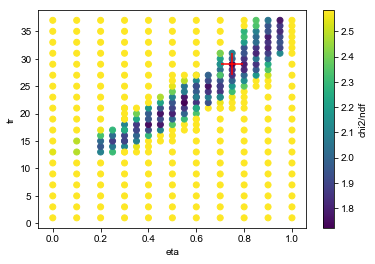

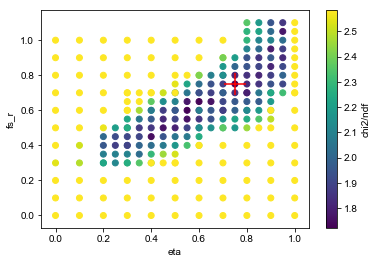

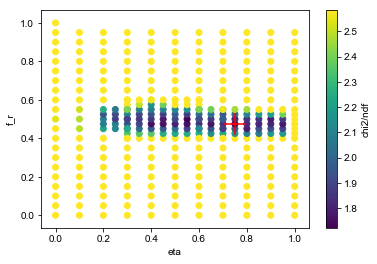

+++++++++++++++++++++++++++++++++++++++++++++
slice 1


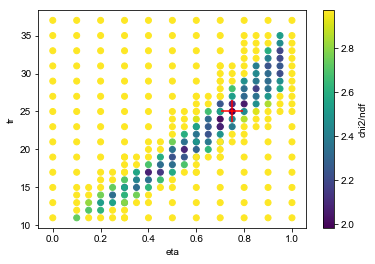

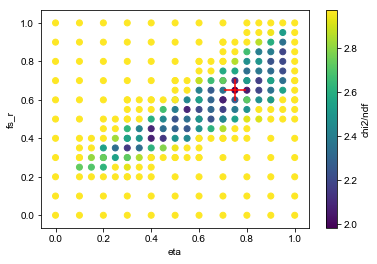

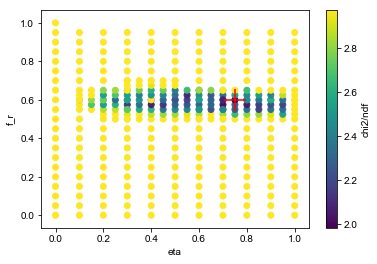

+++++++++++++++++++++++++++++++++++++++++++++
slice 2


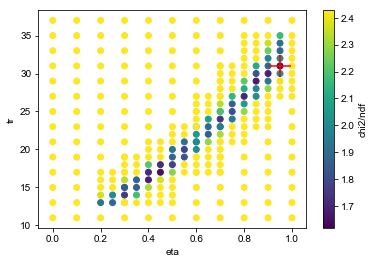

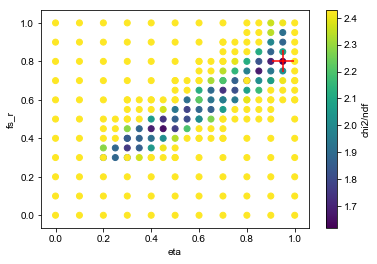

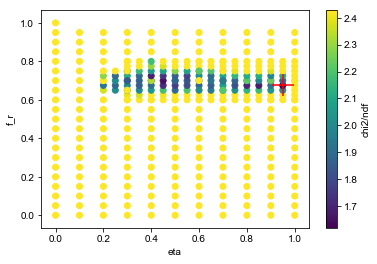

+++++++++++++++++++++++++++++++++++++++++++++
slice 3


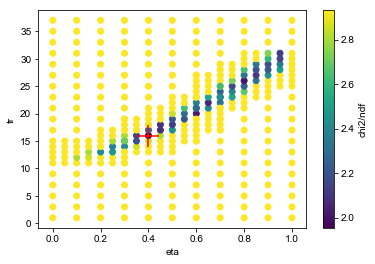

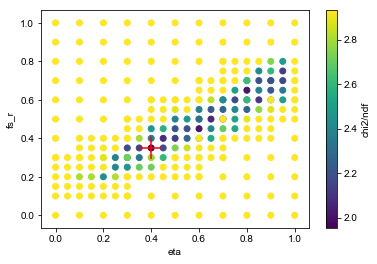

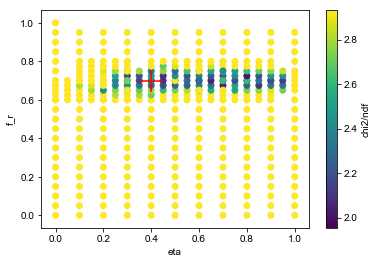

+++++++++++++++++++++++++++++++++++++++++++++


In [37]:
for i, df in enumerate(ddf_er_0_rec):
    print('slice %d' % i)
    plot_all_slices_rec(df)
    print('+++++++++++++++++++++++++++++++++++++++++++++')

## Systematic errors

### Production

In [34]:
# May want to think a little bit about this one. Here are the defaults:
#    t_min = -10.,
#    t_max = 125.,
#    error_offset  = 1e-4 , 
    
settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], 
                                  [-14, 110, 0], [-6, 140, 2e-4], [2, 2, 1e-4], block_size=100000)

Loaded 240 settings.


In [35]:
for ddf, dset in zip(dddf, dsets):
    if dset in []:
        print('Skipping dset %s ...' % dset)
        continue
    print('Now processing dset %s' % dset)
    systscan = min_per_e_syst(ddf, dset, settings)

  0%|          | 0/240 [00:00<?, ?it/s]

Now processing dset er


  0%|          | 0/240 [00:00<?, ?it/s]

         chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    1.028181   er      5      2        0.0000  0.245     500000        True   
1    0.979268   er      5      2        0.0001  0.235     500000        True   
2    0.862031   er      5      2        0.0002  0.235     500000        True   
3    1.043548   er      5      2        0.0000  0.245     500000        True   
4    0.994163   er      5      2        0.0001  0.235     500000        True   
5    0.875567   er      5      2        0.0002  0.235     500000        True   
6    1.049764   er      5      2        0.0000  0.245     500000        True   
7    1.002243   er      5      2        0.0001  0.235     500000        True   
8    0.885793   er      5      2        0.0002  0.235     500000        True   
9    1.066167   er      5      2        0.0000  0.245     500000        True   
10   1.017224   er      5      2        0.0001  0.235     500000        True   
11   0.899631   er      5      2        

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    1.111830   er     10      5        0.0000  0.175     500000        True   
1    0.987591   er     10      5        0.0001  0.175     500000        True   
2    0.786977   er     10      5        0.0002  0.175     500000        True   
3    1.093204   er     10      5        0.0000  0.175     500000        True   
4    0.986429   er     10      5        0.0001  0.175     500000        True   
5    0.793172   er     10      5        0.0002  0.175     500000        True   
6    1.110690   er     10      5        0.0000  0.175     500000        True   
7    1.002505   er     10      5        0.0001  0.175     500000        True   
8    0.806246   er     10      5        0.0002  0.175     500000        True   
9    1.110989   er     10      5        0.0000  0.175     500000        True   
10   1.008556   er     10      5        0.0001  0.175     500000        True   
11   0.815002   er     10      5        

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2 dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0    1.790473   er     20     10        0.0000  0.18    1000000        True   
1    1.444027   er     20     10        0.0001  0.18    1000000        True   
2    1.003546   er     20     10        0.0002  0.18    1000000        True   
3    1.765418   er     20     10        0.0000  0.18    1000000        True   
4    1.450398   er     20     10        0.0001  0.18    1000000        True   
5    1.014318   er     20     10        0.0002  0.18    1000000        True   
6    1.764645   er     20     10        0.0000  0.18    1000000        True   
7    1.464051   er     20     10        0.0001  0.18    1000000        True   
8    1.027662   er     20     10        0.0002  0.18    1000000        True   
9    1.762346   er     20     10        0.0000  0.18    1000000        True   
10   1.474878   er     20     10        0.0001  0.18    1000000        True   
11   1.039894   er     20     10        0.0002  0.18

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2 dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0    2.596408   er     30     20        0.0000  0.17    1000000        True   
1    1.855269   er     30     20        0.0001  0.17    1000000        True   
2    1.151319   er     30     20        0.0002  0.17    1000000        True   
3    2.530125   er     30     20        0.0000  0.17    1000000        True   
4    1.860458   er     30     20        0.0001  0.17    1000000        True   
5    1.162560   er     30     20        0.0002  0.17    1000000        True   
6    2.515174   er     30     20        0.0000  0.17    1000000        True   
7    1.876378   er     30     20        0.0001  0.17    1000000        True   
8    1.177232   er     30     20        0.0002  0.17    1000000        True   
9    2.514486   er     30     20        0.0000  0.17    1000000        True   
10   1.893530   er     30     20        0.0001  0.17    1000000        True   
11   1.192278   er     30     20        0.0002  0.17

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    3.530470   er     50     30        0.0000  0.145    2000000        True   
1    2.304479   er     50     30        0.0001  0.145    2000000        True   
2    1.318582   er     50     30        0.0002  0.145    2000000        True   
3    3.428075   er     50     30        0.0000  0.145    2000000        True   
4    2.313134   er     50     30        0.0001  0.145    2000000        True   
5    1.331768   er     50     30        0.0002  0.145    2000000        True   
6    3.394980   er     50     30        0.0000  0.145    2000000        True   
7    2.332484   er     50     30        0.0001  0.145    2000000        True   
8    1.348252   er     50     30        0.0002  0.145    2000000        True   
9    3.373849   er     50     30        0.0000  0.145    2000000        True   
10   2.350392   er     50     30        0.0001  0.145    2000000        True   
11   1.364293   er     50     30        

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    3.956787   er     70     50        0.0000  0.130    2000000        True   
1    2.312921   er     70     50        0.0001  0.130    2000000        True   
2    1.214799   er     70     50        0.0002  0.130    2000000        True   
3    3.811186   er     70     50        0.0000  0.130    2000000        True   
4    2.319653   er     70     50        0.0001  0.130    2000000        True   
5    1.225943   er     70     50        0.0002  0.130    2000000        True   
6    3.743225   er     70     50        0.0000  0.130    2000000        True   
7    2.335238   er     70     50        0.0001  0.130    2000000        True   
8    1.239732   er     70     50        0.0002  0.130    2000000        True   
9    3.712453   er     70     50        0.0000  0.130    2000000        True   
10   2.353306   er     70     50        0.0001  0.130    2000000        True   
11   1.254255   er     70     50        

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    1.211867   nr      5      2        0.0000  0.225     500000        True   
1    1.102356   nr      5      2        0.0001  0.230     500000        True   
2    0.917235   nr      5      2        0.0002  0.230     500000        True   
3    1.176096   nr      5      2        0.0000  0.225     500000        True   
4    1.084442   nr      5      2        0.0001  0.230     500000        True   
5    0.915062   nr      5      2        0.0002  0.230     500000        True   
6    1.141805   nr      5      2        0.0000  0.225     500000        True   
7    1.066316   nr      5      2        0.0001  0.230     500000        True   
8    0.913029   nr      5      2        0.0002  0.230     500000        True   
9    1.121155   nr      5      2        0.0000  0.230     500000        True   
10   1.052690   nr      5      2        0.0001  0.230     500000        True   
11   0.911117   nr      5      2        

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    1.914605   nr     10      5        0.0000  0.255     500000        True   
1    1.675048   nr     10      5        0.0001  0.255     500000        True   
2    1.299956   nr     10      5        0.0002  0.255     500000        True   
3    1.909054   nr     10      5        0.0000  0.255     500000        True   
4    1.686014   nr     10      5        0.0001  0.255     500000        True   
5    1.315067   nr     10      5        0.0002  0.255     500000        True   
6    1.915750   nr     10      5        0.0000  0.255     500000        True   
7    1.702779   nr     10      5        0.0001  0.255     500000        True   
8    1.332701   nr     10      5        0.0002  0.255     500000        True   
9    1.935973   nr     10      5        0.0000  0.255     500000        True   
10   1.724913   nr     10      5        0.0001  0.255     500000        True   
11   1.352276   nr     10      5        

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    3.988406   nr     15     10        0.0000  0.245    1000000        True   
1    3.303821   nr     15     10        0.0001  0.245    1000000        True   
2    2.370567   nr     15     10        0.0002  0.245    1000000        True   
3    3.981900   nr     15     10        0.0000  0.245    1000000        True   
4    3.333829   nr     15     10        0.0001  0.245    1000000        True   
5    2.401357   nr     15     10        0.0002  0.245    1000000        True   
6    4.034877   nr     15     10        0.0000  0.245    1000000        True   
7    3.384775   nr     15     10        0.0001  0.245    1000000        True   
8    2.439822   nr     15     10        0.0002  0.245    1000000        True   
9    4.091476   nr     15     10        0.0000  0.245    1000000        True   
10   3.436896   nr     15     10        0.0001  0.245    1000000        True   
11   2.479205   nr     15     10        

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    1.755675  er_l      5      2        0.0000  0.250     500000        True   
1    1.652492  er_l      5      2        0.0001  0.250     500000        True   
2    1.478399  er_l      5      2        0.0002  0.250     500000        True   
3    1.707160  er_l      5      2        0.0000  0.250     500000        True   
4    1.628254  er_l      5      2        0.0001  0.250     500000        True   
5    1.477071  er_l      5      2        0.0002  0.250     500000        True   
6    1.725764  er_l      5      2        0.0000  0.250     500000        True   
7    1.648835  er_l      5      2        0.0001  0.250     500000        True   
8    1.498416  er_l      5      2        0.0002  0.250     500000        True   
9    1.611657  er_l      5      2        0.0000  0.250     500000        True   
10   1.569510  er_l      5      2        0.0001  0.250     500000        True   
11   1.462694  er_l      5  

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0    1.343431  er_l     10      5        0.0000  0.16     500000        True   
1    1.175118  er_l     10      5        0.0001  0.16     500000        True   
2    0.940356  er_l     10      5        0.0002  0.16     500000        True   
3    1.311174  er_l     10      5        0.0000  0.16     500000        True   
4    1.170103  er_l     10      5        0.0001  0.16     500000        True   
5    0.946637  er_l     10      5        0.0002  0.16     500000        True   
6    1.293280  er_l     10      5        0.0000  0.16     500000        True   
7    1.170687  er_l     10      5        0.0001  0.16     500000        True   
8    0.955059  er_l     10      5        0.0002  0.16     500000        True   
9    1.278403  er_l     10      5        0.0000  0.16     500000        True   
10   1.169640  er_l     10      5        0.0001  0.16     500000        True   
11   0.962153  er_l     10      5       

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    1.827412  er_l     20     10        0.0000  0.120    1000000        True   
1    1.388563  er_l     20     10        0.0001  0.120    1000000        True   
2    0.943029  er_l     20     10        0.0002  0.120    1000000        True   
3    1.757987  er_l     20     10        0.0000  0.120    1000000        True   
4    1.382800  er_l     20     10        0.0001  0.120    1000000        True   
5    0.949401  er_l     20     10        0.0002  0.120    1000000        True   
6    1.684213  er_l     20     10        0.0000  0.120    1000000        True   
7    1.372277  er_l     20     10        0.0001  0.120    1000000        True   
8    0.954119  er_l     20     10        0.0002  0.120    1000000        True   
9    1.664876  er_l     20     10        0.0000  0.120    1000000        True   
10   1.376082  er_l     20     10        0.0001  0.120    1000000        True   
11   0.963296  er_l     20  

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    2.262156  er_l     30     20        0.0000  0.085    1000000        True   
1    1.488684  er_l     30     20        0.0001  0.085    1000000        True   
2    0.870699  er_l     30     20        0.0002  0.085    1000000        True   
3    2.148212  er_l     30     20        0.0000  0.085    1000000        True   
4    1.482446  er_l     30     20        0.0001  0.085    1000000        True   
5    0.875937  er_l     30     20        0.0002  0.085    1000000        True   
6    2.076259  er_l     30     20        0.0000  0.085    1000000        True   
7    1.481310  er_l     30     20        0.0001  0.085    1000000        True   
8    0.882658  er_l     30     20        0.0002  0.085    1000000        True   
9    2.033209  er_l     30     20        0.0000  0.085    1000000        True   
10   1.482871  er_l     30     20        0.0001  0.085    1000000        True   
11   0.890016  er_l     30  

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    2.883876  er_l     50     30        0.0000  0.055    2000000        True   
1    1.664579  er_l     50     30        0.0001  0.055    2000000        True   
2    0.906544  er_l     50     30        0.0002  0.055    2000000        True   
3    2.697031  er_l     50     30        0.0000  0.055    2000000        True   
4    1.656348  er_l     50     30        0.0001  0.055    2000000        True   
5    0.911386  er_l     50     30        0.0002  0.055    2000000        True   
6    2.584859  er_l     50     30        0.0000  0.055    2000000        True   
7    1.654832  er_l     50     30        0.0001  0.055    2000000        True   
8    0.918120  er_l     50     30        0.0002  0.055    2000000        True   
9    2.516075  er_l     50     30        0.0000  0.055    2000000        True   
10   1.656106  er_l     50     30        0.0001  0.055    2000000        True   
11   0.925535  er_l     50  

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    4.847524  er_l     70     50        0.0000  0.035    2000000        True   
1    2.676232  er_l     70     50        0.0001  0.050    2000000        True   
2    1.367395  er_l     70     50        0.0002  0.055    2000000        True   
3    4.648024  er_l     70     50        0.0000  0.035    2000000        True   
4    2.686767  er_l     70     50        0.0001  0.050    2000000        True   
5    1.380563  er_l     70     50        0.0002  0.055    2000000        True   
6    4.530521  er_l     70     50        0.0000  0.035    2000000        True   
7    2.701241  er_l     70     50        0.0001  0.050    2000000        True   
8    1.395472  er_l     70     50        0.0002  0.055    2000000        True   
9    4.443123  er_l     70     50        0.0000  0.050    2000000        True   
10   2.706845  er_l     70     50        0.0001  0.050    2000000        True   
11   1.413546  er_l     70  

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    1.481309  nr_l      5      2        0.0000  0.255     500000        True   
1    1.324174  nr_l      5      2        0.0001  0.255     500000        True   
2    1.082372  nr_l      5      2        0.0002  0.255     500000        True   
3    1.390989  nr_l      5      2        0.0000  0.255     500000        True   
4    1.274104  nr_l      5      2        0.0001  0.255     500000        True   
5    1.066276  nr_l      5      2        0.0002  0.255     500000        True   
6    1.352936  nr_l      5      2        0.0000  0.255     500000        True   
7    1.257149  nr_l      5      2        0.0001  0.255     500000        True   
8    1.066110  nr_l      5      2        0.0002  0.255     500000        True   
9    1.335828  nr_l      5      2        0.0000  0.255     500000        True   
10   1.249991  nr_l      5      2        0.0001  0.255     500000        True   
11   1.068933  nr_l      5  

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    2.323515  nr_l     10      5        0.0000  0.295     500000        True   
1    2.017567  nr_l     10      5        0.0001  0.295     500000        True   
2    1.558501  nr_l     10      5        0.0002  0.295     500000        True   
3    2.313040  nr_l     10      5        0.0000  0.295     500000        True   
4    2.029333  nr_l     10      5        0.0001  0.295     500000        True   
5    1.576110  nr_l     10      5        0.0002  0.295     500000        True   
6    2.293383  nr_l     10      5        0.0000  0.295     500000        True   
7    2.037258  nr_l     10      5        0.0001  0.295     500000        True   
8    1.592662  nr_l     10      5        0.0002  0.295     500000        True   
9    2.300979  nr_l     10      5        0.0000  0.295     500000        True   
10   2.054873  nr_l     10      5        0.0001  0.295     500000        True   
11   1.612541  nr_l     10  

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    3.670577  nr_l     15     10        0.0000  0.320    1000000        True   
1    2.989216  nr_l     15     10        0.0001  0.320    1000000        True   
2    2.085234  nr_l     15     10        0.0002  0.315    1000000        True   
3    3.613496  nr_l     15     10        0.0000  0.320    1000000        True   
4    2.999131  nr_l     15     10        0.0001  0.320    1000000        True   
5    2.106302  nr_l     15     10        0.0002  0.315    1000000        True   
6    3.614886  nr_l     15     10        0.0000  0.320    1000000        True   
7    3.029297  nr_l     15     10        0.0001  0.320    1000000        True   
8    2.135056  nr_l     15     10        0.0002  0.315    1000000        True   
9    3.637012  nr_l     15     10        0.0000  0.320    1000000        True   
10   3.063882  nr_l     15     10        0.0001  0.320    1000000        True   
11   2.165113  nr_l     15  

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    1.714185  er_0     20     10        0.0000  0.130    1000000        True   
1    1.227913  er_0     20     10        0.0001  0.130    1000000        True   
2    0.777188  er_0     20     10        0.0002  0.130    1000000        True   
3    1.636623  er_0     20     10        0.0000  0.130    1000000        True   
4    1.224901  er_0     20     10        0.0001  0.130    1000000        True   
5    0.782965  er_0     20     10        0.0002  0.130    1000000        True   
6    1.610178  er_0     20     10        0.0000  0.130    1000000        True   
7    1.231377  er_0     20     10        0.0001  0.130    1000000        True   
8    0.791531  er_0     20     10        0.0002  0.130    1000000        True   
9    1.566478  er_0     20     10        0.0000  0.130    1000000        True   
10   1.228160  er_0     20     10        0.0001  0.130    1000000        True   
11   0.797533  er_0     20  

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    2.512533  er_0     30     20        0.0000  0.090    1000000        True   
1    1.623245  er_0     30     20        0.0001  0.090    1000000        True   
2    0.936193  er_0     30     20        0.0002  0.085    1000000        True   
3    2.411820  er_0     30     20        0.0000  0.090    1000000        True   
4    1.627420  er_0     30     20        0.0001  0.090    1000000        True   
5    0.945206  er_0     30     20        0.0002  0.085    1000000        True   
6    2.347650  er_0     30     20        0.0000  0.090    1000000        True   
7    1.634084  er_0     30     20        0.0001  0.090    1000000        True   
8    0.954814  er_0     30     20        0.0002  0.085    1000000        True   
9    2.284210  er_0     30     20        0.0000  0.090    1000000        True   
10   1.634980  er_0     30     20        0.0001  0.090    1000000        True   
11   0.960283  er_0     30  

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0    1.947057  er_0     40     30        0.0000  0.090    1000000        True   
1    1.089516  er_0     40     30        0.0001  0.050    1000000        True   
2    0.596532  er_0     40     30        0.0002  0.050    1000000        True   
3    1.785958  er_0     40     30        0.0000  0.090    1000000        True   
4    1.082394  er_0     40     30        0.0001  0.050    1000000        True   
5    0.599389  er_0     40     30        0.0002  0.050    1000000        True   
6    1.676590  er_0     40     30        0.0000  0.050    1000000        True   
7    1.075997  er_0     40     30        0.0001  0.050    1000000        True   
8    0.602412  er_0     40     30        0.0002  0.050    1000000        True   
9    1.598976  er_0     40     30        0.0000  0.050    1000000        True   
10   1.070474  er_0     40     30        0.0001  0.050    1000000        True   
11   0.605482  er_0     40  

100%|██████████| 240/240 [3:50:32<00:00, 57.29s/it]  

         chi2  dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0    2.838370  er_0     50     40        0.0000  0.05    1000000        True   
1    1.642966  er_0     50     40        0.0001  0.06    1000000        True   
2    0.843652  er_0     50     40        0.0002  0.06    1000000        True   
3    2.652932  er_0     50     40        0.0000  0.05    1000000        True   
4    1.644613  er_0     50     40        0.0001  0.06    1000000        True   
5    0.850592  er_0     50     40        0.0002  0.06    1000000        True   
6    2.501581  er_0     50     40        0.0000  0.05    1000000        True   
7    1.644826  er_0     50     40        0.0001  0.06    1000000        True   
8    0.857160  er_0     50     40        0.0002  0.06    1000000        True   
9    2.434142  er_0     50     40        0.0000  0.05    1000000        True   
10   1.653828  er_0     50     40        0.0001  0.06    1000000        True   
11   0.866124  er_0     50     40       

In [36]:
systscan_rec = min_per_e_syst(ddf_er_0_rec, 'er_0_rec', settings)

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset   eta    f_r    fs  fs_r  \
0    2.403323  er_0     20     10        0.0000  0.55  0.500  0.23  0.60   
1    1.769260  er_0     20     10        0.0001  0.75  0.475  0.23  0.75   
2    1.158854  er_0     20     10        0.0002  0.75  0.475  0.23  0.75   
3    2.341327  er_0     20     10        0.0000  0.55  0.500  0.23  0.60   
4    1.776368  er_0     20     10        0.0001  0.75  0.475  0.23  0.75   
5    1.171327  er_0     20     10        0.0002  0.75  0.475  0.23  0.75   
6    2.328025  er_0     20     10        0.0000  0.55  0.500  0.23  0.60   
7    1.792674  er_0     20     10        0.0001  0.75  0.475  0.23  0.75   
8    1.186720  er_0     20     10        0.0002  0.75  0.475  0.23  0.75   
9    2.266837  er_0     20     10        0.0000  0.55  0.500  0.23  0.60   
10   1.789984  er_0     20     10        0.0001  0.75  0.475  0.23  0.75   
11   1.195782  er_0     20     10        0.0002  0.75  0.475  0.23  0.75   
12   2.15242

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset   eta    f_r    fs  fs_r  \
0    3.112425  er_0     30     20        0.0000  0.70  0.600  0.23  0.60   
1    2.046820  er_0     30     20        0.0001  0.70  0.600  0.23  0.60   
2    1.179898  er_0     30     20        0.0002  0.70  0.575  0.23  0.60   
3    3.022382  er_0     30     20        0.0000  0.70  0.600  0.23  0.60   
4    2.058273  er_0     30     20        0.0001  0.70  0.600  0.23  0.60   
5    1.193039  er_0     30     20        0.0002  0.70  0.575  0.23  0.60   
6    2.966454  er_0     30     20        0.0000  0.70  0.600  0.23  0.60   
7    2.071602  er_0     30     20        0.0001  0.70  0.600  0.23  0.60   
8    1.206896  er_0     30     20        0.0002  0.70  0.575  0.23  0.60   
9    2.869646  er_0     30     20        0.0000  0.70  0.600  0.23  0.60   
10   2.068790  er_0     30     20        0.0001  0.70  0.600  0.23  0.60   
11   1.215244  er_0     30     20        0.0002  0.70  0.575  0.23  0.60   
12   2.74761

  0%|          | 0/240 [00:00<?, ?it/s]

         chi2  dset  e_max  e_min  error_offset   eta    f_r    fs  fs_r  \
0    2.408211  er_0     40     30        0.0000  0.45  0.700  0.23  0.45   
1    1.345789  er_0     40     30        0.0001  0.95  0.675  0.23  0.80   
2    0.725522  er_0     40     30        0.0002  0.95  0.675  0.23  0.80   
3    2.261246  er_0     40     30        0.0000  0.45  0.700  0.23  0.45   
4    1.343592  er_0     40     30        0.0001  0.95  0.675  0.23  0.80   
5    0.730699  er_0     40     30        0.0002  0.95  0.675  0.23  0.80   
6    2.151204  er_0     40     30        0.0000  0.45  0.700  0.23  0.45   
7    1.341041  er_0     40     30        0.0001  0.95  0.675  0.23  0.80   
8    0.735760  er_0     40     30        0.0002  0.95  0.675  0.23  0.80   
9    2.012153  er_0     40     30        0.0000  0.55  0.700  0.23  0.50   
10   1.318223  er_0     40     30        0.0001  0.95  0.675  0.23  0.80   
11   0.734634  er_0     40     30        0.0002  0.95  0.675  0.23  0.80   
12   1.86116

100%|██████████| 240/240 [1:12:28<00:00, 18.11s/it]

         chi2  dset  e_max  e_min  error_offset  eta    f_r    fs  fs_r  \
0    3.061174  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
1    1.585050  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
2    0.824226  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
3    2.887008  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
4    1.586287  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
5    0.830992  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
6    2.714773  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
7    1.581224  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
8    0.836021  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
9    2.400925  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
10   1.539235  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
11   0.830116  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
12   2.281343  er_0     5

### Check result

In [33]:
systscan = pickle.load(open('pickle_dir/mins_per_e_er_0_rec.pickle', 'rb'))

In [38]:
systscan[3]

chi2  dset  e_max  e_min  error_offset  eta    f_r    fs  fs_r  \
0    3.061174  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
1    1.585050  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
2    0.824226  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
3    2.887008  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
4    1.586287  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
5    0.830992  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
6    2.714773  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
7    1.581224  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
8    0.836021  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
9    2.400925  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
10   1.539235  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
11   0.830116  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
12   2.281343  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
13   1.491058  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
14   0.815775  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
15   3.028642  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
16   1.567909  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
17   0.814347  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
18   2.856760  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
19   1.568850  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
20   0.820846  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
21   2.686853  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
22   1.563584  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
23   0.825626  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
24   2.377770  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
25   1.522000  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
26   0.819645  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
27   2.259823  er_0     50     40        0.0000  0.6  0.700  0.23  0.45   
28   1.474348  er_0     50     40        0.0001  0.6  0.700  0.23  0.45   
29   0.805371  er_0     50     40        0.0002  0.6  0.700  0.23  0.45   
..        ...   ...    ...    ...           ...  ...    ...   ...   ...   
210  4.514064  er_0     50     40        0.0000  0.4  0.700  0.23  0.35   
211  2.043338  er_0     50     40        0.0001  0.4  0.700  0.23  0.35   
212  0.956131  er_0     50     40        0.0002  0.4  0.700  0.23  0.35   
213  4.389581  er_0     50     40        0.0000  0.4  0.700  0.23  0.35   
214  2.050256  er_0     50     40        0.0001  0.4  0.700  0.23  0.35   
215  0.963341  er_0     50     40        0.0002  0.4  0.700  0.23  0.35   
216  4.268618  er_0     50     40        0.0000  0.4  0.700  0.23  0.35   
217  2.052220  er_0     50     40        0.0001  0.4  0.700  0.23  0.35   
218  0.969151  er_0     50     40        0.0002  0.4  0.700  0.23  0.35   
219  4.031644  er_0     50     40        0.0000  0.4  0.700  0.23  0.35   
220  2.022720  er_0     50     40        0.0001  0.4  0.700  0.23  0.35   
221  0.965557  er_0     50     40        0.0002  0.4  0.700  0.23  0.35   
222  3.945805  er_0     50     40        0.0000  0.4  0.700  0.23  0.35   
223  1.984896  er_0     50     40        0.0001  0.4  0.700  0.23  0.35   
224  0.953671  er_0     50     40        0.0002  0.4  0.700  0.23  0.35   
225  4.819834  er_0     50     40        0.0000  0.3  0.725  0.23  0.35   
226  2.219169  er_0     50     40        0.0001  0.4  0.700  0.23  0.35   
227  1.007443  er_0     50     40        0.0002  0.4  0.700  0.23  0.35   
228  4.705896  er_0     50     40        0.0000  0.3  0.725  0.23  0.35   
229  2.228309  er_0     50     40        0.0001  0.4  0.700  0.23  0.35   
230  1.015233  er_0     50     40        0.0002  0.4  0.700  0.23  0.35   
231  4.594962  er_0     50     40 

## Mock data error and validation

In [43]:
reps = 400

### Build mock data error

Here, build the error for all the data.

In [41]:
for ddf, name in zip(dddf, dsets):
    if name in []: # 'er', 'nr', 'er_l', 'nr_l']:
        print('Skipping dataset %s' % name)
        continue
    all_newfits = []
    all_errs = []
    for df in ddf:
        newfits, err_dict = generate_mock_and_refit(df, reps)
        all_newfits.append(newfits)
        all_errs.append(err_dict)
    pickle.dump((all_errs, all_newfits), open('mock_%s_%d_reps.pickle' % (name, reps), 'wb'))

Dataset er, 2 to 5 keV
Here is the minimum: {'t1': 0.5, 'e_max': 5, 't3': 22.25, 'dset': 'er', 'e_min': 2, 'fs': 0.23499999999999999, 'tts': 2.125, 'stored_stat': True}


100%|██████████| 400/400 [13:53<00:00,  2.10s/it]


Dataset er, 5 to 10 keV
Here is the minimum: {'t1': 1.75, 'e_max': 10, 't3': 23.75, 'dset': 'er', 'e_min': 5, 'fs': 0.17999999999999999, 'tts': 1.625, 'stored_stat': True}


100%|██████████| 400/400 [15:28<00:00,  2.32s/it]


Dataset er, 10 to 20 keV
Here is the minimum: {'t1': 2.75, 'e_max': 20, 't3': 25.0, 'dset': 'er', 'e_min': 10, 'fs': 0.17999999999999999, 'tts': 1.5, 'stored_stat': True}


100%|██████████| 400/400 [16:26<00:00,  2.74s/it]


Dataset er, 20 to 30 keV
Here is the minimum: {'t1': 3.75, 'e_max': 30, 't3': 25.25, 'dset': 'er', 'e_min': 20, 'fs': 0.17000000000000001, 'tts': 1.375, 'stored_stat': True}


100%|██████████| 400/400 [17:23<00:00,  2.58s/it]


Dataset er, 30 to 50 keV
Here is the minimum: {'t1': 4.0, 'e_max': 50, 't3': 25.25, 'dset': 'er', 'e_min': 30, 'fs': 0.14499999999999999, 'tts': 1.375, 'stored_stat': True}


100%|██████████| 400/400 [24:17<00:00,  3.66s/it]


Dataset er, 50 to 70 keV
Here is the minimum: {'t1': 4.5, 'e_max': 70, 't3': 25.5, 'dset': 'er', 'e_min': 50, 'fs': 0.13500000000000001, 'tts': 1.25, 'stored_stat': True}


100%|██████████| 400/400 [26:15<00:00,  3.92s/it]


Dataset nr, 2 to 5 keV
Here is the minimum: {'t1': 0.5, 'e_max': 5, 't3': 21.5, 'dset': 'nr', 'e_min': 2, 'fs': 0.23000000000000001, 'tts': 1.75, 'stored_stat': True}


100%|██████████| 400/400 [15:48<00:00,  2.37s/it]


Dataset nr, 5 to 10 keV
Here is the minimum: {'t1': 1.5, 'e_max': 10, 't3': 21.5, 'dset': 'nr', 'e_min': 5, 'fs': 0.22, 'tts': 1.5, 'stored_stat': True}


100%|██████████| 400/400 [16:26<00:00,  2.46s/it]


Dataset nr, 10 to 15 keV
Here is the minimum: {'t1': 2.75, 'e_max': 15, 't3': 22.0, 'dset': 'nr', 'e_min': 10, 'fs': 0.245, 'tts': 1.25, 'stored_stat': True}


100%|██████████| 400/400 [15:08<00:00,  2.24s/it]


Dataset er_l, 2 to 5 keV
Here is the minimum: {'t1': 0.25, 'e_max': 5, 't3': 23.25, 'dset': 'er_l', 'e_min': 2, 'fs': 0.25, 'tts': 2.125, 'stored_stat': True}


100%|██████████| 400/400 [19:09<00:00,  2.91s/it]


Dataset er_l, 5 to 10 keV
Here is the minimum: {'t1': 1.75, 'e_max': 10, 't3': 24.0, 'dset': 'er_l', 'e_min': 5, 'fs': 0.16, 'tts': 1.75, 'stored_stat': True}


100%|██████████| 400/400 [20:15<00:00,  3.02s/it]


Dataset er_l, 10 to 20 keV
Here is the minimum: {'t1': 2.0, 'e_max': 20, 't3': 24.5, 'dset': 'er_l', 'e_min': 10, 'fs': 0.12000000000000001, 'tts': 1.5, 'stored_stat': True}


100%|██████████| 400/400 [30:02<00:00,  4.52s/it]


Dataset er_l, 20 to 30 keV
Here is the minimum: {'t1': 3.5, 'e_max': 30, 't3': 25.5, 'dset': 'er_l', 'e_min': 20, 'fs': 0.085000000000000006, 'tts': 1.5, 'stored_stat': True}


100%|██████████| 400/400 [46:16<00:00,  6.98s/it]


Dataset er_l, 30 to 50 keV
Here is the minimum: {'t1': 2.0, 'e_max': 50, 't3': 26.25, 'dset': 'er_l', 'e_min': 30, 'fs': 0.055, 'tts': 1.625, 'stored_stat': True}


100%|██████████| 400/400 [48:17<00:00,  7.19s/it]


Dataset er_l, 50 to 70 keV
Here is the minimum: {'t1': 0.25, 'e_max': 70, 't3': 27.25, 'dset': 'er_l', 'e_min': 50, 'fs': 0.050000000000000003, 'tts': 1.5, 'stored_stat': True}


100%|██████████| 400/400 [30:45<00:00,  4.64s/it]


Dataset nr_l, 2 to 5 keV
Here is the minimum: {'t1': 2.5, 'e_max': 5, 't3': 22.25, 'dset': 'nr_l', 'e_min': 2, 'fs': 0.255, 'tts': 1.5, 'stored_stat': True}


100%|██████████| 400/400 [35:09<00:00,  5.32s/it]


Dataset nr_l, 5 to 10 keV
Here is the minimum: {'t1': 3.25, 'e_max': 10, 't3': 23.0, 'dset': 'nr_l', 'e_min': 5, 'fs': 0.29499999999999998, 'tts': 1.375, 'stored_stat': True}


100%|██████████| 400/400 [37:00<00:00,  5.58s/it]


Dataset nr_l, 10 to 15 keV
Here is the minimum: {'t1': 4.0, 'e_max': 15, 't3': 24.0, 'dset': 'nr_l', 'e_min': 10, 'fs': 0.33000000000000002, 'tts': 1.25, 'stored_stat': True}


100%|██████████| 400/400 [1:12:19<00:00, 10.83s/it]


Dataset er_0, 10 to 20 keV
Here is the minimum: {'t1': 2.25, 'e_max': 20, 't3': 30.0, 'dset': 'er_0', 'e_min': 10, 'fs': 0.13, 'tts': 1.75, 'stored_stat': True}


100%|██████████| 400/400 [35:59<00:00,  5.32s/it]


Dataset er_0, 20 to 30 keV
Here is the minimum: {'t1': 2.25, 'e_max': 30, 't3': 31.25, 'dset': 'er_0', 'e_min': 20, 'fs': 0.089999999999999997, 'tts': 1.625, 'stored_stat': True}


100%|██████████| 400/400 [35:56<00:00,  5.37s/it]


Dataset er_0, 30 to 40 keV
Here is the minimum: {'t1': 2.5, 'e_max': 40, 't3': 32.5, 'dset': 'er_0', 'e_min': 30, 'fs': 0.059999999999999998, 'tts': 1.625, 'stored_stat': True}


100%|██████████| 400/400 [36:40<00:00,  5.51s/it]


Dataset er_0, 40 to 50 keV
Here is the minimum: {'t1': 1.0, 'e_max': 50, 't3': 33.25, 'dset': 'er_0', 'e_min': 40, 'fs': 0.059999999999999998, 'tts': 1.875, 'stored_stat': True}


100%|██████████| 400/400 [3:46:30<00:00, 34.01s/it]  


In [42]:
all_newfits = []
all_errs = []

ddf = ddf_er_0_rec
name = 'er_0_rec'

for df in ddf:
    newfits, err_dict = generate_mock_and_refit(df, reps)
    all_newfits.append(newfits)
    all_errs.append(err_dict)
pickle.dump((all_errs, all_newfits), open('mock_%s_%d_reps.pickle' % (name, reps), 'wb'))

Dataset er_0, 10 to 20 keV
Here is the minimum: {'t1': 1.5, 'f_r': 0.47499999999999998, 's1_model': 'recombination', 'dset': 'er_0', 'eta': 0.75, 'fs_r': 0.75, 'e_max': 20, 't3': 21.5, 'e_min': 10, 'tr': 29.0, 'fs': 0.23000000000000001, 'tts': 1.5, 'stored_stat': True}


100%|██████████| 400/400 [1:03:52<00:00,  9.63s/it]


Dataset er_0, 20 to 30 keV
Here is the minimum: {'t1': 1.5, 'f_r': 0.59999999999999998, 's1_model': 'recombination', 'dset': 'er_0', 'eta': 0.75, 'fs_r': 0.65000000000000002, 'e_max': 30, 't3': 21.5, 'e_min': 20, 'tr': 25.0, 'fs': 0.23000000000000001, 'tts': 1.5, 'stored_stat': True}


100%|██████████| 400/400 [50:55<00:00,  7.63s/it]


Dataset er_0, 30 to 40 keV
Here is the minimum: {'t1': 1.5, 'f_r': 0.67500000000000004, 's1_model': 'recombination', 'dset': 'er_0', 'eta': 0.94999999999999996, 'fs_r': 0.80000000000000004, 'e_max': 40, 't3': 21.5, 'e_min': 30, 'tr': 31.0, 'fs': 0.23000000000000001, 'tts': 1.5, 'stored_stat': True}


100%|██████████| 400/400 [50:57<00:00,  7.66s/it]


Dataset er_0, 40 to 50 keV
Here is the minimum: {'t1': 1.5, 'f_r': 0.69999999999999996, 's1_model': 'recombination', 'dset': 'er_0', 'eta': 0.40000000000000002, 'fs_r': 0.34999999999999998, 'e_max': 50, 't3': 21.5, 'e_min': 40, 'tr': 16.0, 'fs': 0.23000000000000001, 'tts': 1.5, 'stored_stat': True}


100%|██████████| 400/400 [1:04:31<00:00,  9.76s/it]


### Read result back

In [37]:
all_errs_list, all_newfits_list = read_mock_data(dsets = dsets, reps = reps)

Giving you the error for these datasets:  ['er', 'nr', 'er_l', 'nr_l', 'er_0']


In [44]:
all_errs_list_rec, all_newfits_list_rec = read_mock_data(dsets = ['er_0_rec'], reps=reps)

Giving you the error for these datasets:  ['er_0_rec']


### Inspection

In [39]:
dseti = 3
var = 't3'

print('Choosing dataset %s' % dsets[dseti])


Choosing dataset nr_l


In [40]:
x_plot = range(len(dddf[dseti]))
y_feed = [minvalue(df)[var] for df in dddf[dseti]] # The value used for the mock datasets
y_med  = [err[var + '_median'] for err in all_errs_list[dseti]]
y_mean = [err[var + '_mean'] for err in all_errs_list[dseti]]
dyplus = [err['d' + var + '+'] for err in all_errs_list[dseti]]
dymin  = [err['d' + var + '-'] for err in all_errs_list[dseti]]
dysig  = [err['d' + var] for err in all_errs_list[dseti]]

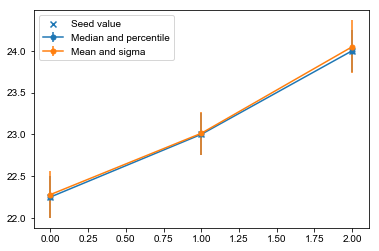

In [41]:
plt.scatter(x_plot, y_feed, label='Seed value', marker='x')
plt.errorbar(x_plot, y_med, (dymin, dyplus), marker='.', markersize = 10, label='Median and percentile')
plt.errorbar(x_plot, y_mean, dysig, marker='.', markersize = 10, label='Mean and sigma')
plt.legend()

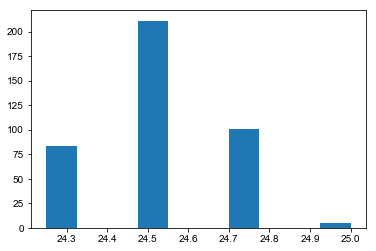

In [42]:
plt.hist(all_newfits_list[2][2]['t3'])
plt.show()

## x production

Here we produce dataframes containing the errors, basically, all the point that will be in the large plot with all the panels.

### Statistical

In [61]:
x_er, x_nr, x_er_l, x_nr_l, x_er_0 = process_mins_mock(dddf, all_errs_list, dsets)

NameError: name 'all_errs_list' is not defined

In [64]:
x_er_0_rec = process_mins_mock([ddf_er_0_rec], all_errs_list_rec, ['er_0_rec'])[0]

In [ ]:
X = [x_er, x_nr, x_er_l, x_nr_l, x_er_0]

In [ ]:
# A little taste of what is in the dataframes
print([key for key in x_er.keys().values if 'fs' in key])

### Systematic

In [47]:
for x, ddf, dset in zip(X, dddf, dsets):
    stat_err = process_mins(ddf, dset) # This will actually read the files
    for key in ['t3', 't1', 'fs', 'tts']:
        x['d' + key + '_syst'] = stat_err['d' + key]

Read 240 settings in 6 bins from file.
Read 240 settings in 3 bins from file.
Read 240 settings in 6 bins from file.
Read 240 settings in 3 bins from file.
Read 240 settings in 4 bins from file.


In [65]:
stat_err = process_mins(ddf_er_0_rec, 'er_0_rec') # This will actually read the file
for key in ['tr', 'eta', 'fs_r', 'f_r', 'chi2']:
    x_er_0_rec['d' + key + '_syst'] = stat_err['d' + key]

Read 240 settings in 4 bins from file.


In [66]:
print([key for key in x_er_0_rec.keys().values if 'chi2' in key])

['chi2', 'dchi2_syst']


### Combination

Here we make a combination

In [50]:
for x, ddf, dset in zip(X, dddf, dsets):
    for key in ['t3', 't1', 'fs', 'tts']:
        x['d' + key + '+'] = np.sqrt(x['d' + key + '_syst']**2 + x['d' + key + '_stat']**2)
        x['d' + key + '-'] = np.sqrt(x['d' + key + '_syst']**2 + x['d' + key + '_stat']**2)
        replace_me = x[key] - x['d' + key + '-'] < 0
        if any(replace_me):
            print('Warning for dataset %s key %s' % (dset, key))
            print('Using asymmetric error for %d datasets' % (sum(replace_me)))
            
            x['d' + key + '-'][replace_me] = np.sqrt(x['d' + key + '_syst'][replace_me]**2 + 
                                                     x['d' + key + '-_stat'][replace_me]**2)
            x['d' + key + '+'][replace_me] = np.sqrt(x['d' + key + '_syst'][replace_me]**2 + 
                                                     x['d' + key + '+_stat'][replace_me]**2)
        replace_me = x[key] - x['d' + key + '-'] < 0


Warning for dataset er key t1
Using asymmetric error for 1 datasets
Warning for dataset er_l key t1
Using asymmetric error for 2 datasets


### Store it

In [51]:
pickle.dump(X, open('X.pickle', 'wb'))

In [67]:
pickle.dump(x_er_0_rec, open('X_rec.pickle', 'wb'))

### Recall it

In [38]:
X = pickle.load(open('X.pickle', 'rb'))

## Killing sigma

In [39]:
Y = []
for dset, ddf, x in zip(dsets, dddf, X):
    ddf_new = kill_tts_ddf(ddf, tts=1.5, verbose=False)
    y = pd.DataFrame()
    y['e'] = x['e']
    y['de'] = x['de']

    for key in ['t1', 't3', 'fs']:
        y[key] = [minvalue(df)[key] for df in ddf_new]
    Y.append(y)


Setting tts to 1.500000
Setting tts to 1.500000
Setting tts to 1.500000
Setting tts to 1.500000
Setting tts to 1.500000


## Check the grids

In [48]:
ddf = ddf_er_l

Selecting 4965 of 16000 values (31.0 %)


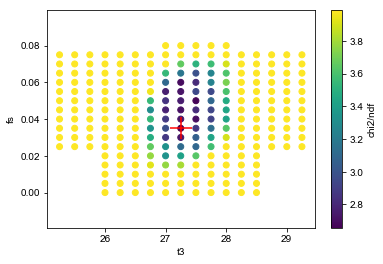

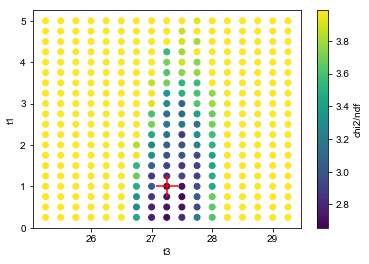

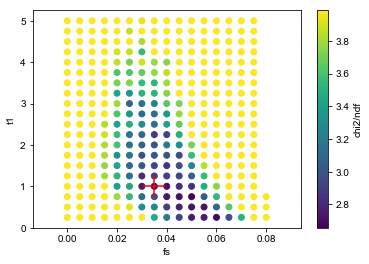

In [51]:
plot_all_slices_killed(ddf[5], tts=1.625)

## Statistical errors

In [40]:
reps = 100

### Produce

In [42]:
for ddf, name in zip(dddf, dsets):
    if name in []: # 'er', 'nr', 'er_l', 'nr_l']:
        print('Skipping dataset %s' % name)
        continue
    all_newfits = []
    all_errs = []
    for df in ddf:
        newfits = []
        err_dict = []
        for tts in [1.375, 1.5, 1.625]:
            df_new = kill_tts(df, tts = tts)
            try:
                _newfits, _err_dict = generate_mock_and_refit(df_new, reps)
                newfits.append(_newfits)
                err_dict.append(_err_dict)
            except:
                print('ERROR for tts %f' % tts)
                el = df.iloc[0]
                print('Dataset: %s, %d to %d' % (el['dset'], el['e_min'], el['e_max']))

        newfits = pd.concat(newfits)
        el = df.iloc[0]
        err_dict = process_newfits(newfits, el['dset'])
        all_newfits.append(newfits)
        all_errs.append(err_dict)
    pickle.dump((all_errs, all_newfits), open('mock_fixedsigma_%s_%d_reps.pickle' % (name, reps), 'wb'))

Selecting 3883 of 12272 values (31.6 %)
Dataset er, 2 to 5 keV
Here is the minimum: {'t3': 22.5, 'tts': 1.375, 'e_max': 5, 'dset': 'er', 't1': 3.0, 'fs': 0.185, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [02:11<00:00,  1.19s/it]


Selecting 4492 of 12272 values (36.6 %)
Dataset er, 2 to 5 keV
Here is the minimum: {'t3': 22.25, 'tts': 1.5, 'e_max': 5, 'dset': 'er', 't1': 2.25, 'fs': 0.17999999999999999, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [02:13<00:00,  1.30s/it]


Selecting 3897 of 12272 values (31.8 %)
Dataset er, 2 to 5 keV
Here is the minimum: {'t3': 22.25, 'tts': 1.625, 'e_max': 5, 'dset': 'er', 't1': 2.25, 'fs': 0.19500000000000001, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [02:00<00:00,  1.26s/it]


Selecting 3740 of 11508 values (32.5 %)
Dataset er, 5 to 10 keV
Here is the minimum: {'t3': 24.0, 'tts': 1.375, 'e_max': 10, 'dset': 'er', 't1': 2.5, 'fs': 0.17000000000000001, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


Selecting 4028 of 11508 values (35.0 %)
Dataset er, 5 to 10 keV
Here is the minimum: {'t3': 23.5, 'tts': 1.5, 'e_max': 10, 'dset': 'er', 't1': 1.75, 'fs': 0.17499999999999999, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [02:13<00:00,  1.36s/it]


Selecting 3740 of 11508 values (32.5 %)
Dataset er, 5 to 10 keV
Here is the minimum: {'t3': 23.75, 'tts': 1.625, 'e_max': 10, 'dset': 'er', 't1': 1.75, 'fs': 0.17999999999999999, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [02:09<00:00,  1.28s/it]


Selecting 3740 of 11382 values (32.9 %)
Dataset er, 10 to 20 keV
Here is the minimum: {'t3': 25.0, 'tts': 1.375, 'e_max': 20, 'dset': 'er', 't1': 2.75, 'fs': 0.17499999999999999, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:48<00:00,  1.71s/it]


Selecting 3902 of 11382 values (34.3 %)
Dataset er, 10 to 20 keV
Here is the minimum: {'t3': 25.0, 'tts': 1.5, 'e_max': 20, 'dset': 'er', 't1': 2.75, 'fs': 0.17999999999999999, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


Selecting 3740 of 11382 values (32.9 %)
Dataset er, 10 to 20 keV
Here is the minimum: {'t3': 24.75, 'tts': 1.625, 'e_max': 20, 'dset': 'er', 't1': 2.25, 'fs': 0.17999999999999999, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:48<00:00,  1.66s/it]


Selecting 3740 of 11301 values (33.1 %)
Dataset er, 20 to 30 keV
Here is the minimum: {'t3': 25.25, 'tts': 1.375, 'e_max': 30, 'dset': 'er', 't1': 3.75, 'fs': 0.17000000000000001, 'stored_stat': True, 'e_min': 20}


100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


Selecting 3821 of 11301 values (33.8 %)
Dataset er, 20 to 30 keV
Here is the minimum: {'t3': 25.0, 'tts': 1.5, 'e_max': 30, 'dset': 'er', 't1': 3.25, 'fs': 0.16500000000000001, 'stored_stat': True, 'e_min': 20}


100%|██████████| 100/100 [03:05<00:00,  1.87s/it]


Selecting 3740 of 11301 values (33.1 %)
Dataset er, 20 to 30 keV
Here is the minimum: {'t3': 25.0, 'tts': 1.625, 'e_max': 30, 'dset': 'er', 't1': 3.0, 'fs': 0.17000000000000001, 'stored_stat': True, 'e_min': 20}


100%|██████████| 100/100 [03:03<00:00,  1.82s/it]


Selecting 3799 of 11586 values (32.8 %)
Dataset er, 30 to 50 keV
Here is the minimum: {'t3': 25.25, 'tts': 1.375, 'e_max': 50, 'dset': 'er', 't1': 4.0, 'fs': 0.14499999999999999, 'stored_stat': True, 'e_min': 30}


100%|██████████| 100/100 [05:02<00:00,  3.03s/it]


Selecting 3988 of 11586 values (34.4 %)
Dataset er, 30 to 50 keV
Here is the minimum: {'t3': 25.75, 'tts': 1.5, 'e_max': 50, 'dset': 'er', 't1': 4.0, 'fs': 0.155, 'stored_stat': True, 'e_min': 30}


100%|██████████| 100/100 [05:05<00:00,  3.03s/it]


Selecting 3799 of 11586 values (32.8 %)
Dataset er, 30 to 50 keV
Here is the minimum: {'t3': 25.5, 'tts': 1.625, 'e_max': 50, 'dset': 'er', 't1': 3.5, 'fs': 0.16, 'stored_stat': True, 'e_min': 30}


100%|██████████| 100/100 [05:01<00:00,  3.03s/it]


Selecting 3869 of 11805 values (32.8 %)
Dataset er, 50 to 70 keV
Here is the minimum: {'t3': 25.25, 'tts': 1.375, 'e_max': 70, 'dset': 'er', 't1': 4.0, 'fs': 0.125, 'stored_stat': True, 'e_min': 50}


100%|██████████| 100/100 [05:37<00:00,  3.30s/it]


Selecting 4067 of 11805 values (34.5 %)
Dataset er, 50 to 70 keV
Here is the minimum: {'t3': 25.25, 'tts': 1.5, 'e_max': 70, 'dset': 'er', 't1': 4.0, 'fs': 0.13, 'stored_stat': True, 'e_min': 50}


100%|██████████| 100/100 [05:37<00:00,  3.36s/it]


Selecting 3869 of 11805 values (32.8 %)
Dataset er, 50 to 70 keV
Here is the minimum: {'t3': 25.5, 'tts': 1.625, 'e_max': 70, 'dset': 'er', 't1': 3.75, 'fs': 0.13500000000000001, 'stored_stat': True, 'e_min': 50}


100%|██████████| 100/100 [05:33<00:00,  3.33s/it]


Selecting 3816 of 11856 values (32.2 %)
Dataset nr, 2 to 5 keV
Here is the minimum: {'t3': 21.5, 'tts': 1.375, 'e_max': 5, 'dset': 'nr', 't1': 1.25, 'fs': 0.20499999999999999, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Selecting 4164 of 11856 values (35.1 %)
Dataset nr, 2 to 5 keV
Here is the minimum: {'t3': 21.25, 'tts': 1.5, 'e_max': 5, 'dset': 'nr', 't1': 1.0, 'fs': 0.20499999999999999, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [02:33<00:00,  1.53s/it]


Selecting 3876 of 11856 values (32.7 %)
Dataset nr, 2 to 5 keV
Here is the minimum: {'t3': 21.25, 'tts': 1.625, 'e_max': 5, 'dset': 'nr', 't1': 0.75, 'fs': 0.215, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Selecting 3799 of 11924 values (31.9 %)
Dataset nr, 5 to 10 keV
Here is the minimum: {'t3': 21.5, 'tts': 1.375, 'e_max': 10, 'dset': 'nr', 't1': 1.75, 'fs': 0.215, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [02:19<00:00,  1.38s/it]


Selecting 4224 of 11924 values (35.4 %)
Dataset nr, 5 to 10 keV
Here is the minimum: {'t3': 21.5, 'tts': 1.5, 'e_max': 10, 'dset': 'nr', 't1': 1.5, 'fs': 0.22, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [02:28<00:00,  1.47s/it]


Selecting 3901 of 11924 values (32.7 %)
Dataset nr, 5 to 10 keV
Here is the minimum: {'t3': 21.5, 'tts': 1.625, 'e_max': 10, 'dset': 'nr', 't1': 1.25, 'fs': 0.23000000000000001, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


Selecting 3740 of 11562 values (32.3 %)
Dataset nr, 10 to 15 keV
Here is the minimum: {'t3': 21.75, 'tts': 1.375, 'e_max': 15, 'dset': 'nr', 't1': 2.75, 'fs': 0.245, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Selecting 4082 of 11562 values (35.3 %)
Dataset nr, 10 to 15 keV
Here is the minimum: {'t3': 21.75, 'tts': 1.5, 'e_max': 15, 'dset': 'nr', 't1': 2.25, 'fs': 0.245, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


Selecting 3740 of 11562 values (32.3 %)
Dataset nr, 10 to 15 keV
Here is the minimum: {'t3': 21.75, 'tts': 1.625, 'e_max': 15, 'dset': 'nr', 't1': 1.75, 'fs': 0.25, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:03<00:00,  1.22s/it]


Selecting 3803 of 12002 values (31.7 %)
Dataset er_l, 2 to 5 keV
Here is the minimum: {'t3': 23.25, 'tts': 1.375, 'e_max': 5, 'dset': 'er_l', 't1': 2.25, 'fs': 0.20000000000000001, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [01:48<00:00,  1.12s/it]


Selecting 4353 of 12002 values (36.3 %)
Dataset er_l, 2 to 5 keV
Here is the minimum: {'t3': 23.0, 'tts': 1.5, 'e_max': 5, 'dset': 'er_l', 't1': 1.75, 'fs': 0.19500000000000001, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Selecting 3846 of 12002 values (32.0 %)
Dataset er_l, 2 to 5 keV
Here is the minimum: {'t3': 23.25, 'tts': 1.625, 'e_max': 5, 'dset': 'er_l', 't1': 2.25, 'fs': 0.19500000000000001, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [01:49<00:00,  1.11s/it]


Selecting 3765 of 11990 values (31.4 %)
Dataset er_l, 5 to 10 keV
Here is the minimum: {'t3': 24.0, 'tts': 1.375, 'e_max': 10, 'dset': 'er_l', 't1': 2.75, 'fs': 0.13500000000000001, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [01:52<00:00,  1.11s/it]


Selecting 4485 of 11990 values (37.4 %)
Dataset er_l, 5 to 10 keV
Here is the minimum: {'t3': 24.0, 'tts': 1.5, 'e_max': 10, 'dset': 'er_l', 't1': 2.0, 'fs': 0.14999999999999999, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [02:08<00:00,  1.27s/it]


Selecting 3740 of 11990 values (31.2 %)
Dataset er_l, 5 to 10 keV
Here is the minimum: {'t3': 23.75, 'tts': 1.625, 'e_max': 10, 'dset': 'er_l', 't1': 1.75, 'fs': 0.14999999999999999, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [01:50<00:00,  1.09s/it]


Selecting 3765 of 12767 values (29.5 %)
Dataset er_l, 10 to 20 keV
Here is the minimum: {'t3': 24.75, 'tts': 1.375, 'e_max': 20, 'dset': 'er_l', 't1': 2.25, 'fs': 0.12, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:03<00:00,  1.21s/it]


Selecting 5132 of 12767 values (40.2 %)
Dataset er_l, 10 to 20 keV
Here is the minimum: {'t3': 24.5, 'tts': 1.5, 'e_max': 20, 'dset': 'er_l', 't1': 2.0, 'fs': 0.12, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:31<00:00,  1.50s/it]


Selecting 3870 of 12767 values (30.3 %)
Dataset er_l, 10 to 20 keV
Here is the minimum: {'t3': 24.75, 'tts': 1.625, 'e_max': 20, 'dset': 'er_l', 't1': 1.75, 'fs': 0.13500000000000001, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


Selecting 3740 of 13324 values (28.1 %)
Dataset er_l, 20 to 30 keV
Here is the minimum: {'t3': 25.5, 'tts': 1.375, 'e_max': 30, 'dset': 'er_l', 't1': 3.25, 'fs': 0.085000000000000006, 'stored_stat': True, 'e_min': 20}


100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


Selecting 5794 of 13324 values (43.5 %)
Dataset er_l, 20 to 30 keV
Here is the minimum: {'t3': 25.5, 'tts': 1.5, 'e_max': 30, 'dset': 'er_l', 't1': 3.5, 'fs': 0.085000000000000006, 'stored_stat': True, 'e_min': 20}


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


Selecting 3790 of 13324 values (28.4 %)
Dataset er_l, 20 to 30 keV
Here is the minimum: {'t3': 25.75, 'tts': 1.625, 'e_max': 30, 'dset': 'er_l', 't1': 3.25, 'fs': 0.10000000000000001, 'stored_stat': True, 'e_min': 20}


100%|██████████| 100/100 [02:17<00:00,  1.35s/it]


Selecting 3779 of 13734 values (27.5 %)
Dataset er_l, 30 to 50 keV
Here is the minimum: {'t3': 26.25, 'tts': 1.375, 'e_max': 50, 'dset': 'er_l', 't1': 2.75, 'fs': 0.044999999999999998, 'stored_stat': True, 'e_min': 30}


100%|██████████| 100/100 [02:52<00:00,  1.71s/it]


Selecting 6002 of 13734 values (43.7 %)
Dataset er_l, 30 to 50 keV
Here is the minimum: {'t3': 26.25, 'tts': 1.5, 'e_max': 50, 'dset': 'er_l', 't1': 2.5, 'fs': 0.044999999999999998, 'stored_stat': True, 'e_min': 30}


100%|██████████| 100/100 [03:34<00:00,  2.19s/it]


Selecting 3953 of 13734 values (28.8 %)
Dataset er_l, 30 to 50 keV
Here is the minimum: {'t3': 26.25, 'tts': 1.625, 'e_max': 50, 'dset': 'er_l', 't1': 2.0, 'fs': 0.055, 'stored_stat': True, 'e_min': 30}


100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


Selecting 4950 of 16000 values (30.9 %)
Dataset er_l, 50 to 70 keV
Here is the minimum: {'t3': 27.25, 'tts': 1.375, 'e_max': 70, 'dset': 'er_l', 't1': 1.75, 'fs': 0.025000000000000001, 'stored_stat': True, 'e_min': 50}


100%|██████████| 100/100 [03:28<00:00,  2.04s/it]


Selecting 6085 of 16000 values (38.0 %)
Dataset er_l, 50 to 70 keV
Here is the minimum: {'t3': 27.25, 'tts': 1.5, 'e_max': 70, 'dset': 'er_l', 't1': 0.25, 'fs': 0.050000000000000003, 'stored_stat': True, 'e_min': 50}


100%|██████████| 100/100 [03:47<00:00,  2.29s/it]


Selecting 4965 of 16000 values (31.0 %)
Dataset er_l, 50 to 70 keV
Here is the minimum: {'t3': 27.25, 'tts': 1.625, 'e_max': 70, 'dset': 'er_l', 't1': 1.0, 'fs': 0.035000000000000003, 'stored_stat': True, 'e_min': 50}


100%|██████████| 100/100 [03:25<00:00,  2.04s/it]


Selecting 3740 of 12858 values (29.1 %)
Dataset nr_l, 2 to 5 keV
Here is the minimum: {'t3': 22.0, 'tts': 1.375, 'e_max': 5, 'dset': 'nr_l', 't1': 2.5, 'fs': 0.25, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [02:08<00:00,  1.27s/it]


Selecting 5328 of 12858 values (41.4 %)
Dataset nr_l, 2 to 5 keV
Here is the minimum: {'t3': 22.25, 'tts': 1.5, 'e_max': 5, 'dset': 'nr_l', 't1': 2.5, 'fs': 0.255, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [02:41<00:00,  1.65s/it]


Selecting 3790 of 12858 values (29.5 %)
Dataset nr_l, 2 to 5 keV
Here is the minimum: {'t3': 22.5, 'tts': 1.625, 'e_max': 5, 'dset': 'nr_l', 't1': 2.75, 'fs': 0.26500000000000001, 'stored_stat': True, 'e_min': 2}


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


Selecting 4101 of 13793 values (29.7 %)
Dataset nr_l, 5 to 10 keV
Here is the minimum: {'t3': 23.0, 'tts': 1.375, 'e_max': 10, 'dset': 'nr_l', 't1': 3.25, 'fs': 0.29499999999999998, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


Selecting 5626 of 13793 values (40.8 %)
Dataset nr_l, 5 to 10 keV
Here is the minimum: {'t3': 22.25, 'tts': 1.5, 'e_max': 10, 'dset': 'nr_l', 't1': 2.75, 'fs': 0.28499999999999998, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [02:43<00:00,  1.64s/it]


Selecting 4066 of 13793 values (29.5 %)
Dataset nr_l, 5 to 10 keV
Here is the minimum: {'t3': 22.5, 'tts': 1.625, 'e_max': 10, 'dset': 'nr_l', 't1': 2.5, 'fs': 0.28499999999999998, 'stored_stat': True, 'e_min': 5}


100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


Selecting 6431 of 20937 values (30.7 %)
Dataset nr_l, 10 to 15 keV
Here is the minimum: {'t3': 23.5, 'tts': 1.375, 'e_max': 15, 'dset': 'nr_l', 't1': 3.5, 'fs': 0.32000000000000001, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


Selecting 8123 of 20937 values (38.8 %)
Dataset nr_l, 10 to 15 keV
Here is the minimum: {'t3': 23.25, 'tts': 1.5, 'e_max': 15, 'dset': 'nr_l', 't1': 3.25, 'fs': 0.31, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [03:25<00:00,  2.07s/it]


Selecting 6383 of 20937 values (30.5 %)
Dataset nr_l, 10 to 15 keV
Here is the minimum: {'t3': 23.0, 'tts': 1.625, 'e_max': 15, 'dset': 'nr_l', 't1': 2.75, 'fs': 0.30499999999999999, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:49<00:00,  1.68s/it]


Selecting 3740 of 12948 values (28.9 %)
Dataset er_0, 10 to 20 keV
Here is the minimum: {'t3': 30.5, 'tts': 1.375, 'e_max': 20, 'dset': 'er_0', 't1': 3.5, 'fs': 0.125, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Selecting 5468 of 12948 values (42.2 %)
Dataset er_0, 10 to 20 keV
Here is the minimum: {'t3': 30.25, 'tts': 1.5, 'e_max': 20, 'dset': 'er_0', 't1': 3.0, 'fs': 0.125, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [02:33<00:00,  1.53s/it]


Selecting 3740 of 12948 values (28.9 %)
Dataset er_0, 10 to 20 keV
Here is the minimum: {'t3': 30.25, 'tts': 1.625, 'e_max': 20, 'dset': 'er_0', 't1': 2.75, 'fs': 0.125, 'stored_stat': True, 'e_min': 10}


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Selecting 3740 of 12948 values (28.9 %)
Dataset er_0, 20 to 30 keV
Here is the minimum: {'t3': 31.5, 'tts': 1.375, 'e_max': 30, 'dset': 'er_0', 't1': 3.25, 'fs': 0.085000000000000006, 'stored_stat': True, 'e_min': 20}


100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


Selecting 5468 of 12948 values (42.2 %)
Dataset er_0, 20 to 30 keV
Here is the minimum: {'t3': 31.25, 'tts': 1.5, 'e_max': 30, 'dset': 'er_0', 't1': 2.5, 'fs': 0.085000000000000006, 'stored_stat': True, 'e_min': 20}


100%|██████████| 100/100 [02:41<00:00,  1.60s/it]


Selecting 3740 of 12948 values (28.9 %)
Dataset er_0, 20 to 30 keV
Here is the minimum: {'t3': 31.25, 'tts': 1.625, 'e_max': 30, 'dset': 'er_0', 't1': 2.25, 'fs': 0.089999999999999997, 'stored_stat': True, 'e_min': 20}


100%|██████████| 100/100 [02:06<00:00,  1.24s/it]


Selecting 3740 of 13149 values (28.4 %)
Dataset er_0, 30 to 40 keV
Here is the minimum: {'t3': 32.25, 'tts': 1.375, 'e_max': 40, 'dset': 'er_0', 't1': 2.75, 'fs': 0.050000000000000003, 'stored_stat': True, 'e_min': 30}


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


Selecting 5592 of 13149 values (42.5 %)
Dataset er_0, 30 to 40 keV
Here is the minimum: {'t3': 32.25, 'tts': 1.5, 'e_max': 40, 'dset': 'er_0', 't1': 3.0, 'fs': 0.050000000000000003, 'stored_stat': True, 'e_min': 30}


100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


Selecting 3817 of 13149 values (29.0 %)
Dataset er_0, 30 to 40 keV
Here is the minimum: {'t3': 32.5, 'tts': 1.625, 'e_max': 40, 'dset': 'er_0', 't1': 2.5, 'fs': 0.059999999999999998, 'stored_stat': True, 'e_min': 30}


100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


Selecting 10320 of 33075 values (31.2 %)
Dataset er_0, 40 to 50 keV
Here is the minimum: {'t3': 33.25, 'tts': 1.375, 'e_max': 50, 'dset': 'er_0', 't1': 1.75, 'fs': 0.040000000000000001, 'stored_stat': True, 'e_min': 40}


100%|██████████| 100/100 [04:21<00:00,  2.59s/it]


Selecting 12435 of 33075 values (37.6 %)
Dataset er_0, 40 to 50 keV
Here is the minimum: {'t3': 33.25, 'tts': 1.5, 'e_max': 50, 'dset': 'er_0', 't1': 1.25, 'fs': 0.040000000000000001, 'stored_stat': True, 'e_min': 40}


100%|██████████| 100/100 [05:03<00:00,  3.06s/it]


Selecting 10320 of 33075 values (31.2 %)
Dataset er_0, 40 to 50 keV
Here is the minimum: {'t3': 33.25, 'tts': 1.625, 'e_max': 50, 'dset': 'er_0', 't1': 1.75, 'fs': 0.050000000000000003, 'stored_stat': True, 'e_min': 40}


100%|██████████| 100/100 [04:21<00:00,  2.58s/it]


### Recall

In [41]:
for i, dset in enumerate(dsets):
    all_errs, all_newfits = pickle.load(open('mock_fixedsigma_%s_%d_reps.pickle' % (dset, reps), 'rb'))
    err_df = pd.DataFrame(all_errs)
    Y[i] = pd.concat([pd.DataFrame(all_errs), Y[i]], axis=1)

In [42]:
Y[0]

chi2_mean  chi2_median  dchi2+_stat  dchi2-_stat  dchi2_stat  dfs+_stat  \
0   1.256448     1.229222     0.114405     0.055753    0.098180      0.015   
1   1.121370     1.104405     0.113072     0.069044    0.094125      0.010   
2   1.541520     1.531938     0.093118     0.031914    0.069440      0.005   
3   2.021837     2.017766     0.110323     0.121570    0.090744      0.000   
4   2.445089     2.381367     0.108290     0.026076    0.110642      0.005   
5   2.572839     2.476670     0.229038     0.034699    0.167112      0.005   

   dfs-_stat  dfs_stat  dt1+_stat  dt1-_stat  ...    t1_median    t3_mean  \
0      0.015  0.015208       0.54       0.50  ...         2.50  22.370000   
1      0.005  0.006906       0.50       0.50  ...         2.00  23.777500   
2      0.005  0.004240       0.00       0.50  ...         2.75  24.935833   
3      0.005  0.004028       0.50       0.25  ...         3.25  25.092500   
4      0.010  0.006462       0.00       0.50  ...         4.00  25.491667   
5      0.005  0.004291       0.00       0.25  ...         4.00  25.324167   

   t3_median  tts_mean  tts_median          e        de    t1     t3     fs  
0      22.25       1.5         1.5   3.563720  0.862591  2.25  22.25  0.180  
1      23.75       1.5         1.5   7.553438  1.438209  1.75  23.50  0.175  
2      25.00       1.5         1.5  15.094698  2.852594  2.75  25.00  0.180  
3      25.00       1.5         1.5  25.317731  2.900625  3.25  25.00  0.165  
4      25.50       1.5         1.5  39.487232  5.898528  4.00  25.75  0.155  
5      25.25       1.5         1.5  60.305626  5.775179  4.00  25.25  0.130  

[6 rows x 30 columns]

## Systematical

### Produce

In [43]:
# May want to think a little bit about this one. Here are the defaults:
#    t_min = -10.,
#    t_max = 125.,
#    error_offset  = 1e-4 , 
    
# settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], 
#                                   [-14, 110, 0], [-6, 140, 2e-4], [2, 2, 1e-4], block_size=100000)

settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], 
                                  [-14, 125, 1e-4], [-6, 125, 1e-4], [2, 2, 1e-4], block_size=100000)

Loaded 5 settings.


In [44]:
for ddf, dset in zip(dddf, dsets):
    if dset in []:
        print('Skipping dset %s ...' % dset)
        continue
    print('Now processing dset %s' % dset)
    _ddf = kill_tts_ddf(ddf, tts = 1.5)
    systscan = min_per_e_syst(_ddf, dset + '_killed', settings)

  0%|          | 0/5 [00:00<?, ?it/s]

Now processing dset er
Setting tts to 1.500000
Selecting 4492 of 12272 values (36.6 %)
Selecting 4028 of 11508 values (35.0 %)
Selecting 3902 of 11382 values (34.3 %)
Selecting 3821 of 11301 values (33.8 %)
Selecting 3988 of 11586 values (34.4 %)
Selecting 4067 of 11805 values (34.5 %)


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2 dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0  1.047461   er      5      2        0.0001  0.18     500000        True   
1  1.061689   er      5      2        0.0001  0.18     500000        True   
2  1.070463   er      5      2        0.0001  0.18     500000        True   
3  1.085391   er      5      2        0.0001  0.18     500000        True   
4  1.060863   er      5      2        0.0001  0.18     500000        True   

  stored_stat_value    t1     t3  t_max  t_min  tts  
0              True  2.25  22.25  125.0  -14.0  1.5  
1              True  2.25  22.25  125.0  -12.0  1.5  
2              True  2.25  22.25  125.0  -10.0  1.5  
3              True  2.25  22.25  125.0   -8.0  1.5  
4              True  2.25  22.25  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.007439   er     10      5        0.0001  0.175     500000        True   
1  1.006593   er     10      5        0.0001  0.175     500000        True   
2  1.021211   er     10      5        0.0001  0.175     500000        True   
3  1.027392   er     10      5        0.0001  0.185     500000        True   
4  1.005167   er     10      5        0.0001  0.185     500000        True   

  stored_stat_value    t1    t3  t_max  t_min  tts  
0              True  1.75  23.5  125.0  -14.0  1.5  
1              True  1.75  23.5  125.0  -12.0  1.5  
2              True  1.75  23.5  125.0  -10.0  1.5  
3              True  2.00  24.0  125.0   -8.0  1.5  
4              True  2.00  24.0  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2 dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0  1.421072   er     20     10        0.0001  0.18    1000000        True   
1  1.426372   er     20     10        0.0001  0.18    1000000        True   
2  1.438065   er     20     10        0.0001  0.18    1000000        True   
3  1.447211   er     20     10        0.0001  0.18    1000000        True   
4  1.452464   er     20     10        0.0001  0.18    1000000        True   

  stored_stat_value    t1    t3  t_max  t_min  tts  
0              True  2.75  25.0  125.0  -14.0  1.5  
1              True  2.75  25.0  125.0  -12.0  1.5  
2              True  2.75  25.0  125.0  -10.0  1.5  
3              True  2.75  25.0  125.0   -8.0  1.5  
4              True  2.75  25.0  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.995328   er     30     20        0.0001  0.165    1000000        True   
1  2.001857   er     30     20        0.0001  0.165    1000000        True   
2  2.017766   er     30     20        0.0001  0.165    1000000        True   
3  2.036422   er     30     20        0.0001  0.165    1000000        True   
4  2.060803   er     30     20        0.0001  0.170    1000000        True   

  stored_stat_value    t1     t3  t_max  t_min  tts  
0              True  3.25  25.00  125.0  -14.0  1.5  
1              True  3.25  25.00  125.0  -12.0  1.5  
2              True  3.25  25.00  125.0  -10.0  1.5  
3              True  3.25  25.00  125.0   -8.0  1.5  
4              True  3.50  25.25  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  2.355136   er     50     30        0.0001  0.155    2000000        True   
1  2.363617   er     50     30        0.0001  0.155    2000000        True   
2  2.381367   er     50     30        0.0001  0.155    2000000        True   
3  2.399861   er     50     30        0.0001  0.155    2000000        True   
4  2.433818   er     50     30        0.0001  0.155    2000000        True   

  stored_stat_value   t1     t3  t_max  t_min  tts  
0              True  4.0  25.75  125.0  -14.0  1.5  
1              True  4.0  25.75  125.0  -12.0  1.5  
2              True  4.0  25.75  125.0  -10.0  1.5  
3              True  4.0  25.75  125.0   -8.0  1.5  
4              True  4.0  25.75  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2 dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0  2.419633   er     70     50        0.0001  0.13    2000000        True   
1  2.427131   er     70     50        0.0001  0.13    2000000        True   
2  2.442463   er     70     50        0.0001  0.13    2000000        True   
3  2.459975   er     70     50        0.0001  0.13    2000000        True   
4  2.496799   er     70     50        0.0001  0.13    2000000        True   

  stored_stat_value   t1     t3  t_max  t_min  tts  
0              True  4.0  25.25  125.0  -14.0  1.5  
1              True  4.0  25.25  125.0  -12.0  1.5  
2              True  4.0  25.25  125.0  -10.0  1.5  
3              True  4.0  25.25  125.0   -8.0  1.5  
4              True  4.0  25.25  125.0   -6.0  1.5  
Now processing dset nr
Setting tts to 1.500000
Selecting 4164 of 11856 values (35.1 %)
Selecting 4224 of 11924 values (35.4 %)
Selecting 4082 of 11562 values (35.3 %)


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.117812   nr      5      2        0.0001  0.205     500000        True   
1  1.102288   nr      5      2        0.0001  0.205     500000        True   
2  1.087509   nr      5      2        0.0001  0.205     500000        True   
3  1.075605   nr      5      2        0.0001  0.205     500000        True   
4  1.022923   nr      5      2        0.0001  0.205     500000        True   

  stored_stat_value   t1     t3  t_max  t_min  tts  
0              True  1.0  21.25  125.0  -14.0  1.5  
1              True  1.0  21.25  125.0  -12.0  1.5  
2              True  1.0  21.25  125.0  -10.0  1.5  
3              True  1.0  21.25  125.0   -8.0  1.5  
4              True  1.0  21.25  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2 dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0  1.652972   nr     10      5        0.0001  0.22     500000        True   
1  1.662527   nr     10      5        0.0001  0.22     500000        True   
2  1.676911   nr     10      5        0.0001  0.22     500000        True   
3  1.695135   nr     10      5        0.0001  0.22     500000        True   
4  1.691191   nr     10      5        0.0001  0.22     500000        True   

  stored_stat_value   t1    t3  t_max  t_min  tts  
0              True  1.5  21.5  125.0  -14.0  1.5  
1              True  1.5  21.5  125.0  -12.0  1.5  
2              True  1.5  21.5  125.0  -10.0  1.5  
3              True  1.5  21.5  125.0   -8.0  1.5  
4              True  1.5  21.5  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2 dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  3.284834   nr     15     10        0.0001  0.245    1000000        True   
1  3.311211   nr     15     10        0.0001  0.245    1000000        True   
2  3.355634   nr     15     10        0.0001  0.245    1000000        True   
3  3.401173   nr     15     10        0.0001  0.245    1000000        True   
4  3.441263   nr     15     10        0.0001  0.245    1000000        True   

  stored_stat_value    t1     t3  t_max  t_min  tts  
0              True  2.25  21.75  125.0  -14.0  1.5  
1              True  2.25  21.75  125.0  -12.0  1.5  
2              True  2.25  21.75  125.0  -10.0  1.5  
3              True  2.25  21.75  125.0   -8.0  1.5  
4              True  2.25  21.75  125.0   -6.0  1.5  
Now processing dset er_l
Setting tts to 1.500000
Selecting 4353 of 12002 values (36.3 %)
Selecting 4485 of 11990 values (37.4 %)
Selecting 5132 of 12767 values (40.2 %)
Selecting 5794 of 13324 values (43.5 %

  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.610458  er_l      5      2        0.0001  0.195     500000        True   
1  1.588844  er_l      5      2        0.0001  0.195     500000        True   
2  1.606812  er_l      5      2        0.0001  0.195     500000        True   
3  1.534217  er_l      5      2        0.0001  0.195     500000        True   
4  1.554185  er_l      5      2        0.0001  0.195     500000        True   

  stored_stat_value    t1    t3  t_max  t_min  tts  
0              True  1.75  23.0  125.0  -14.0  1.5  
1              True  1.75  23.0  125.0  -12.0  1.5  
2              True  1.75  23.0  125.0  -10.0  1.5  
3              True  1.75  23.0  125.0   -8.0  1.5  
4              True  1.75  23.0  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.171032  er_l     10      5        0.0001  0.150     500000        True   
1  1.166203  er_l     10      5        0.0001  0.150     500000        True   
2  1.166279  er_l     10      5        0.0001  0.150     500000        True   
3  1.161805  er_l     10      5        0.0001  0.150     500000        True   
4  1.161229  er_l     10      5        0.0001  0.145     500000        True   

  stored_stat_value   t1     t3  t_max  t_min  tts  
0              True  2.0  24.00  125.0  -14.0  1.5  
1              True  2.0  24.00  125.0  -12.0  1.5  
2              True  2.0  24.00  125.0  -10.0  1.5  
3              True  2.0  24.00  125.0   -8.0  1.5  
4              True  2.0  23.75  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0  1.328433  er_l     20     10        0.0001  0.12    1000000        True   
1  1.322466  er_l     20     10        0.0001  0.12    1000000        True   
2  1.312294  er_l     20     10        0.0001  0.12    1000000        True   
3  1.314750  er_l     20     10        0.0001  0.12    1000000        True   
4  1.309506  er_l     20     10        0.0001  0.12    1000000        True   

  stored_stat_value   t1    t3  t_max  t_min  tts  
0              True  2.0  24.5  125.0  -14.0  1.5  
1              True  2.0  24.5  125.0  -12.0  1.5  
2              True  2.0  24.5  125.0  -10.0  1.5  
3              True  2.0  24.5  125.0   -8.0  1.5  
4              True  2.0  24.5  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.442906  er_l     30     20        0.0001  0.085    1000000        True   
1  1.436728  er_l     30     20        0.0001  0.085    1000000        True   
2  1.435053  er_l     30     20        0.0001  0.085    1000000        True   
3  1.435738  er_l     30     20        0.0001  0.085    1000000        True   
4  1.450509  er_l     30     20        0.0001  0.095    1000000        True   

  stored_stat_value   t1     t3  t_max  t_min  tts  
0              True  3.5  25.50  125.0  -14.0  1.5  
1              True  3.5  25.50  125.0  -12.0  1.5  
2              True  3.5  25.50  125.0  -10.0  1.5  
3              True  3.5  25.50  125.0   -8.0  1.5  
4              True  3.5  25.75  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.830710  er_l     50     30        0.0001  0.045    2000000        True   
1  1.826221  er_l     50     30        0.0001  0.045    2000000        True   
2  1.827224  er_l     50     30        0.0001  0.045    2000000        True   
3  1.827794  er_l     50     30        0.0001  0.045    2000000        True   
4  1.855349  er_l     50     30        0.0001  0.045    2000000        True   

  stored_stat_value   t1     t3  t_max  t_min  tts  
0              True  2.5  26.25  125.0  -14.0  1.5  
1              True  2.5  26.25  125.0  -12.0  1.5  
2              True  2.5  26.25  125.0  -10.0  1.5  
3              True  2.5  26.25  125.0   -8.0  1.5  
4              True  2.5  26.25  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0  2.538421  er_l     70     50        0.0001  0.05    2000000        True   
1  2.545738  er_l     70     50        0.0001  0.05    2000000        True   
2  2.556435  er_l     70     50        0.0001  0.05    2000000        True   
3  2.559208  er_l     70     50        0.0001  0.05    2000000        True   
4  2.568896  er_l     70     50        0.0001  0.05    2000000        True   

  stored_stat_value    t1     t3  t_max  t_min  tts  
0              True  0.25  27.25  125.0  -14.0  1.5  
1              True  0.25  27.25  125.0  -12.0  1.5  
2              True  0.25  27.25  125.0  -10.0  1.5  
3              True  0.25  27.25  125.0   -8.0  1.5  
4              True  0.25  27.25  125.0   -6.0  1.5  
Now processing dset nr_l
Setting tts to 1.500000
Selecting 5328 of 12858 values (41.4 %)
Selecting 5626 of 13793 values (40.8 %)
Selecting 8123 of 20937 values (38.8 %)


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.254240  nr_l      5      2        0.0001  0.255     500000        True   
1  1.208962  nr_l      5      2        0.0001  0.255     500000        True   
2  1.193044  nr_l      5      2        0.0001  0.255     500000        True   
3  1.185783  nr_l      5      2        0.0001  0.255     500000        True   
4  1.157101  nr_l      5      2        0.0001  0.255     500000        True   

  stored_stat_value   t1     t3  t_max  t_min  tts  
0              True  2.5  22.25  125.0  -14.0  1.5  
1              True  2.5  22.25  125.0  -12.0  1.5  
2              True  2.5  22.25  125.0  -10.0  1.5  
3              True  2.5  22.25  125.0   -8.0  1.5  
4              True  2.5  22.25  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.917136  nr_l     10      5        0.0001  0.285     500000        True   
1  1.925639  nr_l     10      5        0.0001  0.285     500000        True   
2  1.930511  nr_l     10      5        0.0001  0.285     500000        True   
3  1.944540  nr_l     10      5        0.0001  0.285     500000        True   
4  1.946160  nr_l     10      5        0.0001  0.285     500000        True   

  stored_stat_value    t1     t3  t_max  t_min  tts  
0              True  2.75  22.25  125.0  -14.0  1.5  
1              True  2.75  22.25  125.0  -12.0  1.5  
2              True  2.75  22.25  125.0  -10.0  1.5  
3              True  2.75  22.25  125.0   -8.0  1.5  
4              True  2.75  22.25  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0  3.132936  nr_l     15     10        0.0001  0.31    1000000        True   
1  3.143820  nr_l     15     10        0.0001  0.31    1000000        True   
2  3.172189  nr_l     15     10        0.0001  0.31    1000000        True   
3  3.204508  nr_l     15     10        0.0001  0.31    1000000        True   
4  3.243666  nr_l     15     10        0.0001  0.31    1000000        True   

  stored_stat_value    t1     t3  t_max  t_min  tts  
0              True  3.25  23.25  125.0  -14.0  1.5  
1              True  3.25  23.25  125.0  -12.0  1.5  
2              True  3.25  23.25  125.0  -10.0  1.5  
3              True  3.25  23.25  125.0   -8.0  1.5  
4              True  3.25  23.25  125.0   -6.0  1.5  
Now processing dset er_0
Setting tts to 1.500000
Selecting 5468 of 12948 values (42.2 %)
Selecting 5468 of 12948 values (42.2 %)
Selecting 5592 of 13149 values (42.5 %)
Selecting 12435 of 33075 values (37.6 

  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.403746  er_0     20     10        0.0001  0.125    1000000        True   
1  1.404001  er_0     20     10        0.0001  0.125    1000000        True   
2  1.411964  er_0     20     10        0.0001  0.125    1000000        True   
3  1.405080  er_0     20     10        0.0001  0.125    1000000        True   
4  1.383034  er_0     20     10        0.0001  0.125    1000000        True   

  stored_stat_value   t1     t3  t_max  t_min  tts  
0              True  3.0  30.25  125.0  -14.0  1.5  
1              True  3.0  30.25  125.0  -12.0  1.5  
2              True  3.0  30.25  125.0  -10.0  1.5  
3              True  3.0  30.25  125.0   -8.0  1.5  
4              True  3.0  30.25  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.713287  er_0     30     20        0.0001  0.085    1000000        True   
1  1.718364  er_0     30     20        0.0001  0.085    1000000        True   
2  1.725138  er_0     30     20        0.0001  0.085    1000000        True   
3  1.720421  er_0     30     20        0.0001  0.085    1000000        True   
4  1.704488  er_0     30     20        0.0001  0.085    1000000        True   

  stored_stat_value   t1     t3  t_max  t_min  tts  
0              True  2.5  31.25  125.0  -14.0  1.5  
1              True  2.5  31.25  125.0  -12.0  1.5  
2              True  2.5  31.25  125.0  -10.0  1.5  
3              True  2.5  31.25  125.0   -8.0  1.5  
4              True  2.5  31.25  125.0   -6.0  1.5  


  0%|          | 0/5 [00:00<?, ?it/s]

       chi2  dset  e_max  e_min  error_offset     fs  n_photons stored_stat  \
0  1.527122  er_0     40     30        0.0001  0.050    1000000        True   
1  1.527168  er_0     40     30        0.0001  0.050    1000000        True   
2  1.528065  er_0     40     30        0.0001  0.050    1000000        True   
3  1.529948  er_0     40     30        0.0001  0.050    1000000        True   
4  1.541479  er_0     40     30        0.0001  0.055    1000000        True   

  stored_stat_value    t1     t3  t_max  t_min  tts  
0              True  3.00  32.25  125.0  -14.0  1.5  
1              True  3.00  32.25  125.0  -12.0  1.5  
2              True  3.00  32.25  125.0  -10.0  1.5  
3              True  3.00  32.25  125.0   -8.0  1.5  
4              True  2.75  32.25  125.0   -6.0  1.5  


100%|██████████| 5/5 [00:21<00:00,  4.35s/it]

       chi2  dset  e_max  e_min  error_offset    fs  n_photons stored_stat  \
0  2.042263  er_0     50     40        0.0001  0.04    1000000        True   
1  2.049894  er_0     50     40        0.0001  0.04    1000000        True   
2  2.052360  er_0     50     40        0.0001  0.04    1000000        True   
3  2.032766  er_0     50     40        0.0001  0.04    1000000        True   
4  1.988298  er_0     50     40        0.0001  0.05    1000000        True   

  stored_stat_value    t1     t3  t_max  t_min  tts  
0              True  1.25  33.25  125.0  -14.0  1.5  
1              True  1.25  33.25  125.0  -12.0  1.5  
2              True  1.25  33.25  125.0  -10.0  1.5  
3              True  1.25  33.25  125.0   -8.0  1.5  
4              True  1.25  33.25  125.0   -6.0  1.5  


### Recall

In [43]:
for y, ddf, dset in zip(Y, dddf, dsets):
    _ddf = kill_tts_ddf(ddf, tts=1.5)
    stat_err = process_mins(_ddf, dset + '_killed') # This will actually read the files
    for key in ['t3', 't1', 'fs', 'tts']:
        y['d' + key + '_syst'] = stat_err['d' + key]

Setting tts to 1.500000
Selecting 4492 of 12272 values (36.6 %)
Selecting 4028 of 11508 values (35.0 %)
Selecting 3902 of 11382 values (34.3 %)
Selecting 3821 of 11301 values (33.8 %)
Selecting 3988 of 11586 values (34.4 %)
Selecting 4067 of 11805 values (34.5 %)
Read 5 settings in 6 bins from file.
Setting tts to 1.500000
Selecting 4164 of 11856 values (35.1 %)
Selecting 4224 of 11924 values (35.4 %)
Selecting 4082 of 11562 values (35.3 %)
Read 5 settings in 3 bins from file.
Setting tts to 1.500000
Selecting 4353 of 12002 values (36.3 %)
Selecting 4485 of 11990 values (37.4 %)
Selecting 5132 of 12767 values (40.2 %)
Selecting 5794 of 13324 values (43.5 %)
Selecting 6002 of 13734 values (43.7 %)
Selecting 6085 of 16000 values (38.0 %)
Read 5 settings in 6 bins from file.
Setting tts to 1.500000
Selecting 5328 of 12858 values (41.4 %)
Selecting 5626 of 13793 values (40.8 %)
Selecting 8123 of 20937 values (38.8 %)
Read 5 settings in 3 bins from file.
Setting tts to 1.500000
Selecting 54

## Combine

This is the place to choose how we wish to handle aaaaallllll this information...

In [44]:
for y, ddf, dset in zip(Y, dddf, dsets):
    for key in ['t3', 't1', 'fs']:
        # y[key + '_value'] = y[key]
        
        # OPTION2: mean plus minus std
        y[key + '_value'] = y[key + '_mean']
        y['d' + key + '+'] = np.sqrt(y['d' + key + '_syst']**2 + y['d' + key + '_stat']**2)
        y['d' + key + '-'] = np.sqrt(y['d' + key + '_syst']**2 + y['d' + key + '_stat']**2)
        
        # OPTION3: median and percentiles
#         y[key + '_value'] = y[key + '_median']
#         y['d' + key + '+'] = np.sqrt(y['d' + key + '_syst']**2 + y['d' + key + '+_stat']**2)
#         y['d' + key + '-'] = np.sqrt(y['d' + key + '_syst']**2 + y['d' + key + '-_stat']**2)
        
        
        
        replace_me = y[key + '_value'] - y['d' + key + '-'] < 0
        if any(replace_me):
            print('Warning for dataset %s key %s' % (dset, key))
#             print('Using asymmetric error for %d datasets' % (sum(replace_me)))
#             d[key + '_value'][replace_me] = y[key + '_median']
#             y['d' + key + '-'][replace_me] = np.sqrt(y['d' + key + '_syst'][replace_me]**2 + 
#                                                      y['d' + key + '-_stat'][replace_me]**2)
#             y['d' + key + '+'][replace_me] = np.sqrt(y['d' + key + '_syst'][replace_me]**2 + 
#                                                      y['d' + key + '+_stat'][replace_me]**2)
#         replace_me = y[key + '_value'] - y['d' + key + '-'] < 0
#         if any(replace_me):
#             print('Still there!')


## Dump

In [45]:
pickle.dump(Y, open('Y.pickle', 'wb'))

## Recall

In [179]:
Y = pickle.load(open('Y.pickle', 'rb'))

## Fine grid production

In [112]:
grids = []
for ddf, dset in zip([ddf_er_0], ['er_0']): # zip([ddf_er_l, ddf_nr_l], ['er_l', 'nr_l']):# zip([ddf_er, ddf_nr, ddf_er_l], ['er', 'nr', 'er_l']):
    for df in ddf:
        finegrid = build_fine_grid(df, 20, ['fs', 't3', 't1', 'tts'], [0.01, 0.5, 0.5, 0.25])
        finegrid = pd.DataFrame(finegrid)
        finegrid = remove_common(finegrid, df)
        finegrid = finegrid.to_dict('records')
        grids.append(finegrid)
        # One element
        el = df.iloc[0]
        fn = '/data/xenon/ehogenbi/pulsefit/finegrid/%s_%02d_%02d_fine.pickle' % (el['dset'], el['e_min'], el['e_max'])
        print('Dumping to %s' % fn)
        with open(fn, 'wb') as f:
            pickle.dump(finegrid, f)

Selected 20 values with chi2 ranging from 1.42 to 1.78...
Removed 7329 of 12500 settings that were nonunique, 5171 left...
Also removed 0 points with zero t1 or tts, 5171 left!
Removing 558 of 5171 items, already exist...
Dumping to /data/xenon/ehogenbi/pulsefit/finegrid/er_0_10_20_fine.pickle
Selected 20 values with chi2 ranging from 1.80 to 2.07...
Removed 7725 of 12500 settings that were nonunique, 4775 left...
Also removed 0 points with zero t1 or tts, 4775 left!
Removing 516 of 4775 items, already exist...
Dumping to /data/xenon/ehogenbi/pulsefit/finegrid/er_0_20_30_fine.pickle
Selected 20 values with chi2 ranging from 1.65 to 1.88...
Removed 6821 of 12500 settings that were nonunique, 5679 left...
Also removed 175 points with zero t1 or tts, 5504 left!
Removing 583 of 5504 items, already exist...
Dumping to /data/xenon/ehogenbi/pulsefit/finegrid/er_0_30_40_fine.pickle
Selected 20 values with chi2 ranging from 2.21 to 2.44...
Removed 7533 of 12500 settings that were nonunique, 496

In [261]:
print('Total number of iterations: %d' % (len(np.concatenate(grids))))

Total number of iterations: 61595


In [263]:
grids

[[{'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.75,
   't3': 22.25,
   'tts': 2.375},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.0},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.125},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.25},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.375},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.21,
   'n_photons': 500000,
   't1': 1.0,
   't3': 21.75,
   'tts': 1.625},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.21,
   'n_photons': 500000,
   't1': 1.0,
   't3': 21.75,
   'tts': 1.75},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.21

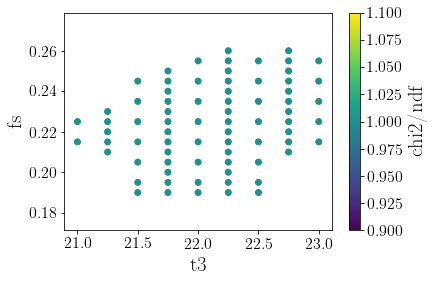

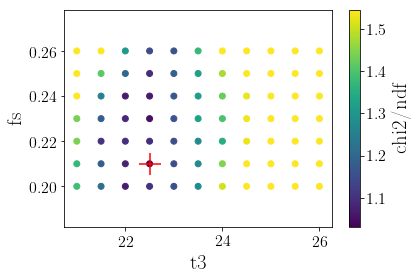

In [252]:
ding = pd.DataFrame(grids[0])
df = ddf_er[0]
ding['chi2'] = np.ones(len(ding))
plot_slice_containing_point(ding, 't3', 'fs', ding.iloc[20])
parslice_2d(df, 't3', 'fs')

### With sigma killed

In [160]:
dsets

['er', 'nr', 'er_l', 'nr_l', 'er_0']

In [177]:
grids = []
counter = 0
for ddf, dset in zip(dddf, dsets):
    _ddf = kill_tts_ddf(ddf, tts=1.5, tol = 0.126)
    
    for df in _ddf:
        finegrid = build_fine_grid(df, 50, ['fs', 't3', 't1', 'tts'], [0.01, 0.5, 0.5, 0.25])
        finegrid = pd.DataFrame(finegrid)
        finegrid = finegrid[(finegrid['tts'] > 1.5 - 0.126) & (finegrid['tts'] < 1.5 + 0.126)]
        finegrid = remove_common(finegrid, df)
        finegrid = finegrid.to_dict('records')
        grids.append(finegrid)
        # One element
        el = df.iloc[0]
        fn = '/data/xenon/ehogenbi/pulsefit/finegrid/%s_%02d_%02d_fine_killedsigma.pickle' % (el['dset'], el['e_min'], el['e_max'])
        print('Dumping %d settings to %s' % (len(finegrid), fn))
        counter = counter + len(finegrid)
        with open(fn, 'wb') as f:
            pickle.dump(finegrid, f)

Setting tts to 1.500000
Selecting 1169 of 10190 values (11.5 %)
Selecting 2281 of 10829 values (21.1 %)
Selecting 2372 of 9064 values (26.2 %)
Selecting 2474 of 9166 values (27.0 %)
Selecting 2438 of 8980 values (27.1 %)
Selecting 2461 of 9055 values (27.2 %)
Selected 50 values with chi2 ranging from 1.08 to 1.16...
Removed 27693 of 31250 settings that were nonunique, 3557 left...
Also removed 0 points with zero t1 or tts, 3557 left!
Removing 462 of 1914 items, already exist...
Dumping 1452 settings to /data/xenon/ehogenbi/pulsefit/finegrid/er_02_05_fine_killedsigma.pickle
Selected 50 values with chi2 ranging from 0.96 to 1.08...
Removed 27306 of 31250 settings that were nonunique, 3944 left...
Also removed 0 points with zero t1 or tts, 3944 left!
Removing 1414 of 2004 items, already exist...
Dumping 590 settings to /data/xenon/ehogenbi/pulsefit/finegrid/er_05_10_fine_killedsigma.pickle
Selected 50 values with chi2 ranging from 1.44 to 1.61...
Removed 27639 of 31250 settings that were 

### Sigma killed another version

In [86]:
counter = 0
for ddf, y in zip(dddf, Y):
    for i, df in enumerate(ddf):
        el = df.iloc[0]
        e_min = el['e_min']
        e_max = el['e_max']
        t3_fit = y.iloc[i]['t3']
        fs_fit = y.iloc[i]['fs']
        
        pconst = dict(
            dset = el['dset'],
            n_photons = np.max(df['n_photons'].values),
            e_min = e_min,
            e_max = e_max,
        )
        
        grid = produce_settings_dicts(['t1', 't3', 'fs', 'tts'], 
                               [0.25, t3_fit - 2, fs_fit - 0.025, 1.375],
                               [5, t3_fit + 2, fs_fit + 0.025, 1.625],
                               [0.25, 0.25, 0.005, 0.125] , **pconst
                              )
        grid = pd.DataFrame(list(grid))
        grid = remove_common(grid, df)
        grid = grid.to_dict('records')
        fn = '/data/xenon/ehogenbi/pulsefit/finegrid/%s_%02d_%02d_fine_killedsigma2.pickle' % (el['dset'], el['e_min'], el['e_max'])
        print('Dumping %d settings to %s' % (len(grid), fn))
        counter = counter + len(grid)
        with open(fn, 'wb') as f:
            pickle.dump(grid, f)
        
        

Loaded 11220 settings.
Removing 1569 of 11220 items, already exist...
Dumping 9651 settings to /data/xenon/ehogenbi/pulsefit/finegrid/er_02_05_fine_killedsigma2.pickle
Loaded 11220 settings.
Removing 2583 of 11220 items, already exist...
Dumping 8637 settings to /data/xenon/ehogenbi/pulsefit/finegrid/er_05_10_fine_killedsigma2.pickle
Loaded 11220 settings.
Removing 2531 of 11220 items, already exist...
Dumping 8689 settings to /data/xenon/ehogenbi/pulsefit/finegrid/er_10_20_fine_killedsigma2.pickle
Loaded 11220 settings.
Removing 2678 of 11220 items, already exist...
Dumping 8542 settings to /data/xenon/ehogenbi/pulsefit/finegrid/er_20_30_fine_killedsigma2.pickle
Loaded 11220 settings.
Removing 2443 of 11220 items, already exist...
Dumping 8777 settings to /data/xenon/ehogenbi/pulsefit/finegrid/er_30_50_fine_killedsigma2.pickle
Loaded 11220 settings.
Removing 2317 of 11220 items, already exist...
Dumping 8903 settings to /data/xenon/ehogenbi/pulsefit/finegrid/er_50_70_fine_killedsigma2

In [88]:
bla1 = pickle.load(open('/data/xenon/ehogenbi/pulsefit/finegrid/er_02_05_fine_killedsigma2.pickle', 'rb'))

In [89]:
bla2 = pickle.load(open('/data/xenon/ehogenbi/pulsefit/finegrid/er_02_05_fine_killedsigma.pickle', 'rb'))

In [91]:
bla1

[{'dset': 'er',
  'e_max': 5,
  'e_min': 2,
  'fs': 0.155,
  'n_photons': 500000,
  't1': 0.25,
  't3': 20.25,
  'tts': 1.375},
 {'dset': 'er',
  'e_max': 5,
  'e_min': 2,
  'fs': 0.155,
  'n_photons': 500000,
  't1': 0.25,
  't3': 20.25,
  'tts': 1.5},
 {'dset': 'er',
  'e_max': 5,
  'e_min': 2,
  'fs': 0.155,
  'n_photons': 500000,
  't1': 0.25,
  't3': 20.25,
  'tts': 1.625},
 {'dset': 'er',
  'e_max': 5,
  'e_min': 2,
  'fs': 0.16,
  'n_photons': 500000,
  't1': 0.25,
  't3': 20.25,
  'tts': 1.375},
 {'dset': 'er',
  'e_max': 5,
  'e_min': 2,
  'fs': 0.16,
  'n_photons': 500000,
  't1': 0.25,
  't3': 20.25,
  'tts': 1.5},
 {'dset': 'er',
  'e_max': 5,
  'e_min': 2,
  'fs': 0.16,
  'n_photons': 500000,
  't1': 0.25,
  't3': 20.25,
  'tts': 1.625},
 {'dset': 'er',
  'e_max': 5,
  'e_min': 2,
  'fs': 0.165,
  'n_photons': 500000,
  't1': 0.25,
  't3': 20.25,
  'tts': 1.375},
 {'dset': 'er',
  'e_max': 5,
  'e_min': 2,
  'fs': 0.165,
  'n_photons': 500000,
  't1': 0.25,
  't3': 20.25,


## Fixing t3

Lux fellows are fixing their t3. What happens if we do, too?

In [148]:
ddf = dddf[4]

In [163]:
df = ddf[3]

In [170]:
for df in ddf:
    _df = deepcopy(df)
    # Fix sigma
    sigma_fix = 1.5
    _df = _df[(_df['tts'] > sigma_fix - 0.001) & (_df['tts'] < sigma_fix + 0.001)]
    print('Minvalue chi2: %f' % (min(df['chi2'])))

Minvalue chi2: 1.374707
Minvalue chi2: 1.657354
Minvalue chi2: 1.456146
Minvalue chi2: 1.859614


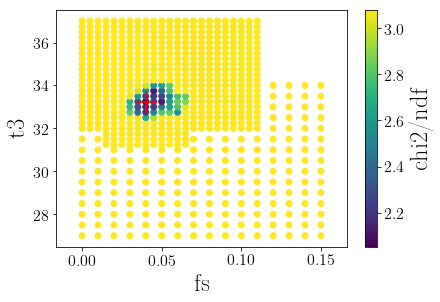

In [165]:
parslice_2d(_df, 'fs', 't3')

In [79]:
df['t3']p

SyntaxError: invalid syntax (<ipython-input-79-c054e36517f8>, line 1)

In [72]:
df.keys()

Index(['chi2', 'dset', 'e_max', 'e_min', 'fs', 'model', 'n_photons', 'spe_err',
       'stored_stat', 'syst_err', 't1', 't3', 'tts', 'ydata',
       'stored_stat_value'],
      dtype='object')

# Recall results

# Pretty plots

## Auxilary data

In [46]:
# Akimov ER
asim_x = [13.5 + 3 * x for x in range(9)]
asim_dx = [1.5 for x in range(9)]
asim_y = np.array([29.1, 30.8, 30.8, 31.85, 32.5, 32.9, 33.0, 34.15, 34.05])
asim_dy = np.array([1.3, 1.2, 1.2,1.3,1.2,1.2,1.1,1.2,1.2]) * 0.5

In [47]:
# Ues NR
uesnr_x  = np.array([6, 8.3, 10.7, 13.2, 16.7])
uesnr_dx = np.array([1.2,1.2,1.2, 1.2, 2.4])
uesnr_y =  np.array([24.7, 24.4, 23.3, 22.2, 21.6])
uesnr_dy = np.array([0.5, 0.4, 0.6, 0.2, 0.55])

In [48]:
ueser_x  = np.array([6, 8.3, 10.7, 13.2, 16.7])
ueser_dx = np.array([1.2,1.2,1.2, 1.2, 2.4])
ueser_y  = np.array([33.05,34.25,33.8,35.7,35.0])
ueser_dy  = np.array([0.5,1.2,0.35,0.65,1.1])

## Eight panel plot

In [47]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


#### Lowfield, highfield

In [45]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks = [2, 5, 10, 20, 30, 50, 70]

f = plt.figure(figsize=(20,25))
gs = gridspec.GridSpec(4, 2, hspace = 0.05, wspace = 0.05) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# Set grid and x limits
for ax in axes:
    ax.set_xlim(2, 70)
    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(xtick) for xtick in xticks])
    ax.grid()
    

for ax in axes:
    if ax == ax6 or ax==ax7:
        continue
    ax.set_xticklabels([])

# Plot titles
ax0.set_title(r'\bf High field (0.5 kV/cm)')
ax1.set_title(r'\bf Low field (0.1 kV/cm)')

# x-axis titles
for ax in [ax6, ax7]:
    ax.set_xlabel('Recoil energy (keV$_{ee}$)')

# Turn off y-axis ticks for 
for ax in [ax1, ax3, ax5, ax7]:
    ax.set_ylabel("")
    ax.set_yticklabels([])

ax0.set_ylabel(r"$\tau_{t}$ (ns)")
ax2.set_ylabel(r"$\tau_{s}$ (ns)")
ax4.set_ylabel(r'$f_s$')
ax6.set_ylabel(r'$\sigma$ (ns)')

for x, l, c, marker in zip([x_er, x_nr], ['ER', 'NR'], ['black', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 't1', 'fs', 'tts'], [ax0, ax2, ax4, ax6]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  
        
for x, l, c, marker in zip([x_er_l, x_nr_l], ['ER', 'NR'], ['black', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 't1', 'fs', 'tts'], [ax1, ax3, ax5, ax7]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  

for ax in [ax0, ax1]:
    ax.set_ylim(20, 28)
for ax in [ax2, ax3]:
    ax.set_ylim(0, 5)
for ax in [ax4, ax5]:
    # Singlet fraction
    ax.set_ylim(0., 0.35)
for ax in [ax6, ax7]:
    # tts
    ax.set_ylim(1, 2.4)
    
for ax in axes:
#     if ax in [ax0, ax1, ax2, ax7]:
#         ax.legend(loc='lower right')
#     if ax in [ax4, ax6]:
#         ax.legend(loc='lower left')
#     if ax in [ax3]:
#         ax.legend(loc='upper right')
    if ax in [ax0, ax1]:
        ax.legend(loc='lower right')
    
plt.savefig('/home/erik/win/notes/giant_plotfig.pdf', bbox_inches='tight')

NameError: name 'gridspec' is not defined

#### ER, NR

In [149]:
save_it = True

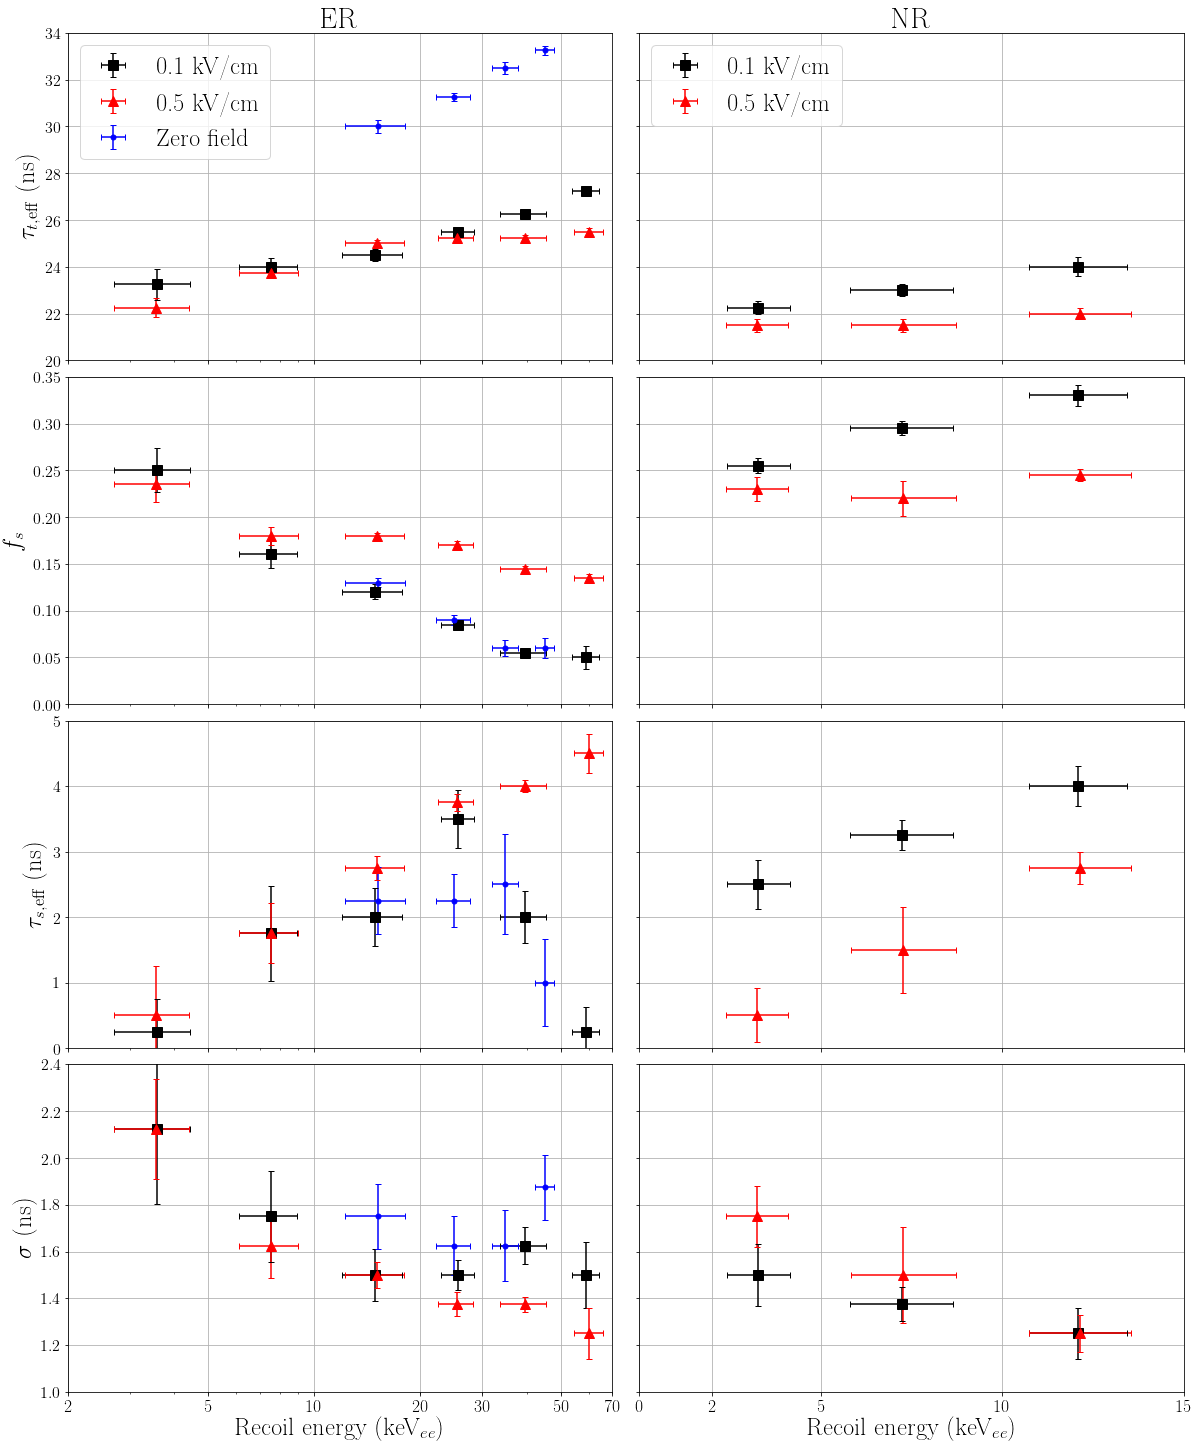

In [153]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks_er = [2, 5, 10, 20, 30, 50, 70]
xticks_nr = [0, 2, 5, 10, 15]

f = plt.figure(figsize=(20,25))
gs = gridspec.GridSpec(4, 2, hspace = 0.05, wspace = 0.05) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]
axes_left  = [ax0, ax2, ax4, ax6]
axes_right = [ax1, ax3, ax5, ax7]
# Set grid and x limits

for ax in axes_right:
    # ax.set_xscale('log')
    ax.grid()
    ax.set_xlim(0, 15)
    ax.set_xticks(xticks_nr)
    ax.set_xticklabels([str(xtick) for xtick in xticks_nr])
    
    
for ax in axes_left:
    ax.set_xscale('log')
    ax.grid()
    ax.set_xlim(2, 70)
    ax.set_xticks(xticks_er)
    ax.set_xticklabels([str(xtick) for xtick in xticks_er])



# Plot titles
ax0.set_title(r'ER')
ax1.set_title(r'NR')

# x-axis titles
for ax in [ax6, ax7]:
    ax.set_xlabel('Recoil energy (keV$_{ee}$)')
    


# Turn off y-axis ticks for 
for ax in axes_right:
    ax.set_ylabel("")
    ax.set_yticklabels([])

ax0.set_ylabel(r"$\tau_{t, {\rm eff}}$ (ns)")
ax2.set_ylabel(r'$f_s$')
ax4.set_ylabel(r"$\tau_{s, {\rm eff}}$ (ns)")
ax6.set_ylabel(r'$\sigma$ (ns)')

for x, l, c, marker in zip([x_er_l, x_er, x_er_0], ['0.1 kV/cm', '0.5 kV/cm', 'Zero field'], 
                           ['black', 'red', 'blue'], ['s', '^', '.']):
    for ypar, ax in zip(['t3', 'fs', 't1', 'tts'], [ax0, ax2, ax4, ax6]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  
        
for x, l, c, marker in zip([x_nr_l, x_nr], ['0.1 kV/cm', '0.5 kV/cm'], ['black', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 'fs', 't1', 'tts'], [ax1, ax3, ax5, ax7]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  

for ax in [ax0, ax1]:
    # t3
    ax.set_ylim(20, 34)
for ax in [ax2, ax3]:
    # fs
    ax.set_ylim(0, 0.35)
for ax in [ax4, ax5]:
    # t1
    ax.set_ylim(0., 5)
for ax in [ax6, ax7]:
    # tts
    ax.set_ylim(1, 2.4)
    
for ax in [ax0, ax1]:
    ax.legend(loc='upper left')
    
    
for ax in axes:#[ax0, ax1, ax2, ax3, ax4, ax5]:
    ax.get_xaxis().set_ticklabels([])
    
ax6.set_xticks(xticks_er)
ax6.set_xticklabels([str(xtick) for xtick in xticks_er])

ax7.set_xticks(xticks_nr)
ax7.set_xticklabels([str(xtick) for xtick in xticks_nr])

if save_it:
    plt.savefig('/home/erik/win/notes/giant_plotfig_ernr.pdf', bbox_inches='tight')

## Fixed sigma

### Sigma plot

In [180]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


NameError: name 'x_er_l' is not defined

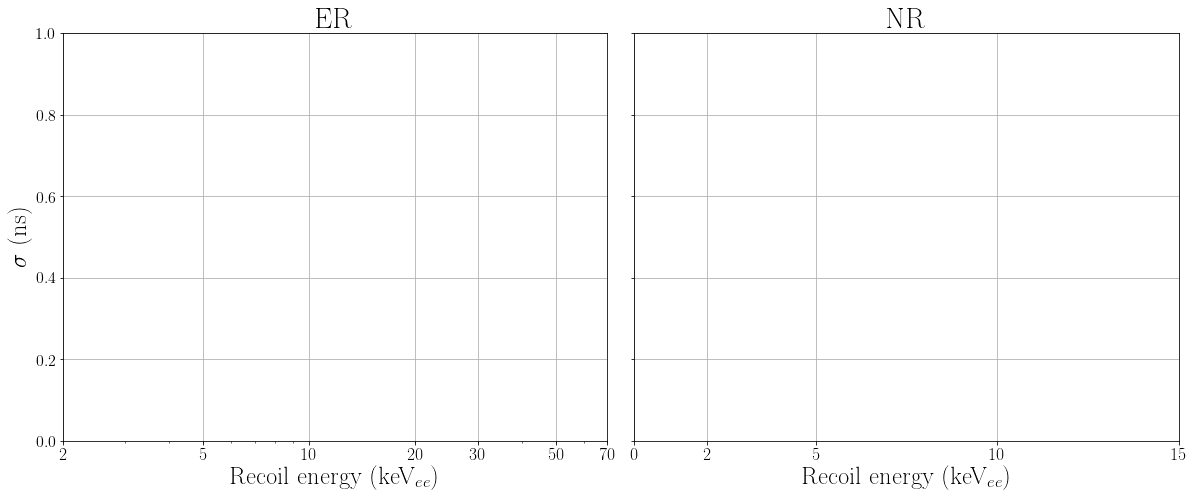

In [181]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks_er = [2, 5, 10, 20, 30, 50, 70]
xticks_nr = [0, 2, 5, 10, 15]

f = plt.figure(figsize=(20,7.5))
gs = gridspec.GridSpec(1, 2, hspace = 0.05, wspace = 0.05) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
axes = [ax0, ax1]
axes_left  = [ax0]
axes_right = [ax1]
# Set grid and x limits

for ax in axes_right:
    # ax.set_xscale('log')
    ax.grid()
    ax.set_xlim(0, 15)
    ax.set_xticks(xticks_nr)
    ax.set_xticklabels([str(xtick) for xtick in xticks_nr])
    
    
for ax in axes_left:
    ax.set_xscale('log')
    ax.grid()
    ax.set_xlim(2, 70)
    ax.set_xticks(xticks_er)
    ax.set_xticklabels([str(xtick) for xtick in xticks_er])

for ax in axes_right:
    ax.set_ylabel("")
    ax.set_yticklabels([])

ax0.set_ylabel(r"$\sigma$ (ns)")    
    
# Plot titles
ax0.set_title(r'ER')
ax1.set_title(r'NR')

# x-axis titles
for ax in [ax0, ax1]:
    ax.set_xlabel('Recoil energy (keV$_{ee}$)')    
    
for x, l, c, marker in zip([x_er_l, x_er, x_er_0], ['0.1 kV/cm', '0.5 kV/cm', 'Zero field'], 
                           ['black', 'red', 'blue'], ['s', '^', '.']):
    for ypar, ax in zip(['tts'], [ax0]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  
        
for x, l, c, marker in zip([x_nr_l, x_nr], ['0.1 kV/cm', '0.5 kV/cm'], ['black', 'red'], ['s', '^']):
    for ypar, ax in zip(['tts'], [ax1]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  
        
for ax in [ax0, ax1]:
    ax.legend(loc='lower left')
    
    
for ax in axes:#[ax0, ax1, ax2, ax3, ax4, ax5]:
    ax.get_xaxis().set_ticklabels([])
    
ax0.set_xticks(xticks_er)
ax0.set_xticklabels([str(xtick) for xtick in xticks_er])

ax1.set_xticks(xticks_nr)
ax1.set_xticklabels([str(xtick) for xtick in xticks_nr])

for ax in axes:
    ax.set_ylim(0, 2.5)
    
    
mid = 1.5
upper = 1.625
lower = 1.375
for ax in axes:
    plt.sca(ax)
    plt.axhline(mid, lw=1.5)
    plt.fill_between((0, 70), (lower, lower), (upper, upper), alpha = 0.5)

    
plt.savefig('/home/erik/win/notes/sigma_only.pdf', bbox_inches='tight')

### Six panel plot

In [52]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


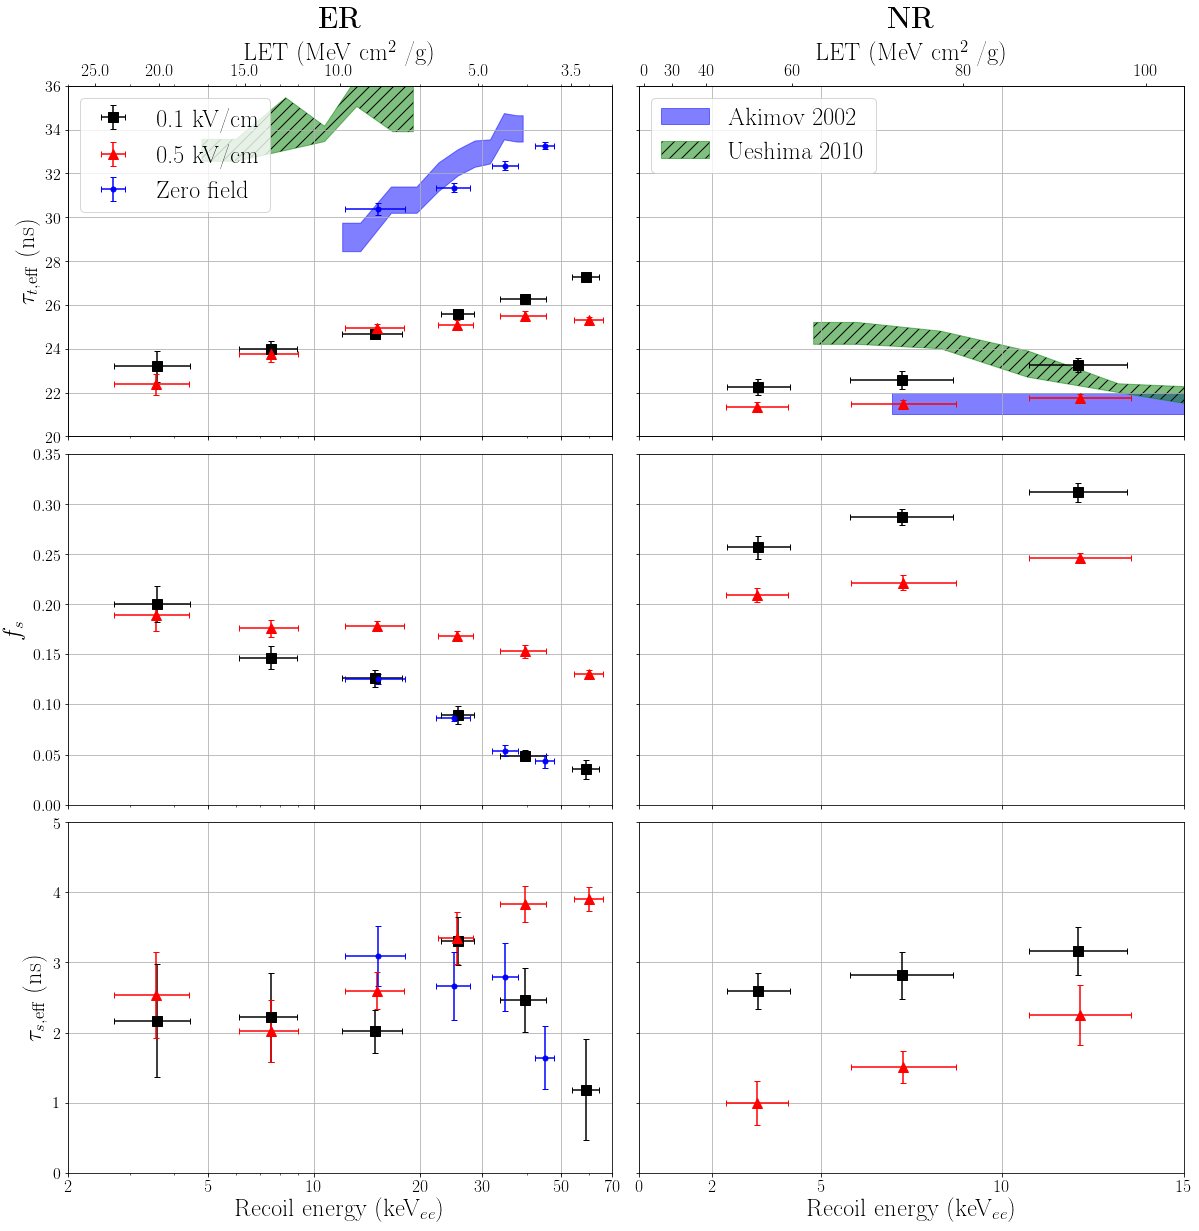

In [98]:
save_it = True
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks_er = [2, 5, 10, 20, 30, 50, 70]
xticks_nr = [0, 2, 5, 10, 15]

f = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(3, 2, hspace = 0.05, wspace = 0.05) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

axes = [ax0, ax1, ax2, ax3, ax4, ax5]
axes_left  = [ax0, ax2, ax4]
axes_right = [ax1, ax3, ax5]
# Set grid and x limits

for ax in axes_right:
    # ax.set_xscale('log')
    ax.grid()
    ax.set_xlim(0, 15)
    ax.set_xticks(xticks_nr)
    ax.set_xticklabels([str(xtick) for xtick in xticks_nr])
    
    
for ax in axes_left:
    ax.set_xscale('log')
    ax.grid()
    ax.set_xlim(2, 70)
    ax.set_xticks(xticks_er)
    ax.set_xticklabels([str(xtick) for xtick in xticks_er])



# Plot titles
ax0.set_title(r'{\bf ER}', y=1.15)
ax1.set_title(r'{\bf NR}', y=1.15)

# x-axis titles
for ax in [ax4, ax5]:
    ax.set_xlabel('Recoil energy (keV$_{ee}$)')
    


# Turn off y-axis ticks for 
for ax in axes_right:
    ax.set_ylabel("")
    ax.set_yticklabels([])

ax0.set_ylabel(r"$\tau_{t, {\rm eff}}$ (ns)")
ax2.set_ylabel(r'$f_s$')
ax4.set_ylabel(r"$\tau_{s, {\rm eff}}$ (ns)")

for x, l, c, marker in zip([Y[2], Y[0], Y[4]], ['0.1 kV/cm', '0.5 kV/cm', 'Zero field'], 
                           ['black', 'red', 'blue'], ['s', '^', '.']):
    for ypar, ax in zip(['t3', 'fs', 't1'], [ax0, ax2, ax4]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar + '_value'],  yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  
        
for x, l, c, marker in zip([Y[3], Y[1]], ['0.1 kV/cm', '0.5 kV/cm'], ['black', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 'fs', 't1'], [ax1, ax3, ax5]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar + '_value'],  yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                    # label=l, 
                    marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  

for ax in [ax0, ax1]:
    # t3
    ax.set_ylim(20, 36)
for ax in [ax2, ax3]:
    # fs
    ax.set_ylim(0, 0.35)
for ax in [ax4, ax5]:
    # t1
    ax.set_ylim(0., 5)
    
for ax in [ax0]:
    ax.legend(loc='upper left')
    
for ax in axes:
    ax.get_xaxis().set_ticklabels([])
    
ax4.set_xticks(xticks_er)
ax4.set_xticklabels([str(xtick) for xtick in xticks_er])

ax5.set_xticks(xticks_nr)
ax5.set_xticklabels([str(xtick) for xtick in xticks_nr])

plt.sca(ax0)
# Akimov points ER
asim_x_plot = np.concatenate([[asim_x[0] - asim_dx[0]], asim_x, [asim_x[-1] + asim_dx[-1]]])
asim_y_plot = np.concatenate([[asim_y[0]], asim_y, [asim_y[-1]]])
asim_dy_plot = np.concatenate([[asim_dy[0]], asim_dy, [asim_dy[-1]]])
plt.fill_between(asim_x_plot, asim_y_plot - asim_dy_plot, asim_y_plot + asim_dy_plot, color='blue', alpha=0.5)

# Ueshima points ER
ues_x_plot = np.concatenate([[ueser_x[0] - ueser_dx[0]], ueser_x, [ueser_x[-1] + ueser_dx[-1]]])
ues_y_plot = np.concatenate([[ueser_y[0]], ueser_y, [ueser_y[-1]]])
ues_dy_plot = np.concatenate([[ueser_dy[0]], ueser_dy, [ueser_dy[-1]]])
plt.fill_between(ues_x_plot, ues_y_plot - ues_dy_plot, ues_y_plot + ues_dy_plot, alpha=0.5, color='green', hatch='//')


plt.sca(ax1)
# Akimov points NR
akim_x_nr = np.array([6.95, 7.3, 8.0, 14.1, 14.2, 15.0])
akim_y_nr = np.array([20.3, 21.4, 21.1, 21.2, 20.6, 21.4])
akim_dy_nr = np.array([1.2 for _y in akim_y_nr])
plt.fill_between([akim_x_nr[0], akim_x_nr[-1]], [21.5 - 0.5, 21.5-0.5], [21.5 + 0.5, 21.5 + 0.5], 
                 color='blue', alpha=0.5, label=r'Akimov 2002')

# Ueshima points NR
ues_x_plot = np.concatenate([[uesnr_x[0] - uesnr_dx[0]], uesnr_x, [uesnr_x[-1] + uesnr_dx[-1]]])
ues_y_plot = np.concatenate([[uesnr_y[0]], uesnr_y, [uesnr_y[-1]]])
ues_dy_plot = np.concatenate([[uesnr_dy[0]], uesnr_dy, [uesnr_dy[-1]]])
plt.fill_between(ues_x_plot, ues_y_plot - ues_dy_plot, ues_y_plot + ues_dy_plot, alpha=0.5, color='green', hatch='//',
                 label=r'Ueshima 2010')

handles, labels = ax1.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], loc='upper left')

# Top legend
plt.sca(ax0)
plt.twiny()
plt.xlim(2,70)
plt.xscale('log')
plt.xlabel(r'LET (\si{MeV cm^2 /g})')
LET_er_labels = np.array([3.5, 5, 10, 15, 20, 25])
LET_er_positions = LET_er(LET_er_labels, mode='LET_inv')
plt.xticks(LET_er_positions, LET_er_labels)

plt.sca(ax1)
plt.twiny()
plt.xlim(0,15)
plt.xlabel(r'LET (\si{MeV cm^2 /g})')
LET_nr_labels = [0.001, 30, 40, 60, 80, 100]
LET_nr_positions = LET_nr(LET_nr_labels, mode='LET_inv', model='SRIM')
# Convert recoil energy
LET_nr_positions = keV_to_keVee(LET_nr_positions)
# Revert label to zero
LET_nr_labels[0] = 0
plt.xticks(LET_nr_positions, LET_nr_labels)


if save_it:
    plt.savefig('/home/erik/win/notes/fig10.pdf', bbox_inches='tight')
plt.show()

In [78]:
%run 07_LET.ipynb

In [79]:
LET_nr(e=15, mode='LET', model='SRIM')

49.13793103448276

In [80]:
LET_nr(e=1, mode='LET', model='SRIM')

13.10344827586207

In [82]:
LET_nr(e=keVee_to_keV(15), mode='LET', model='SRIM')

113.09866884464122

In [72]:
LET_er_positions

array([ 53.5       ,  29.16666667,  11.81818182,   6.375     ,
         3.625     ,   2.38709677])

In [ ]:
LET_er

### The Recombination Model

In [48]:
x = x_er_0_rec

In [49]:
keys = ['tr', 'eta', 'f_r', 'fs_r']
for key in keys:
    # Symmetric errors
    #x['d' + key + '+'] = np.sqrt(x['d' + key + '_stat']**2 + x['d' + key + '_syst']**2)
    #x['d' + key + '-'] = np.sqrt(x['d' + key + '_stat']**2 + x['d' + key + '_syst']**2)
    
    # Asymmetric errors
    x['d' + key + '+'] = np.sqrt(
        (x['d' + key + '+_stat'] + x[key + '_median'] - x[key])**2 + 
        (x['d' + key + '_syst'])**2)
    x['d' + key + '-'] = np.sqrt(
        (x['d' + key + '-_stat'] - x[key + '_median'] + x[key])**2 + 
        (x['d' + key + '_syst'])**2)
    
for key in [ 'eta', 'f_r', 'fs_r']  :
    overflow = (x[key] + x['d' + key + '+']) > 1
    if np.any(overflow):
        print('Overflow detected in %s' % key)
        x['d' + key + '+'] = x['d' + key + '+'] * np.invert(overflow) + overflow * (1 - x[key])
    

Overflow detected in eta


In [53]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


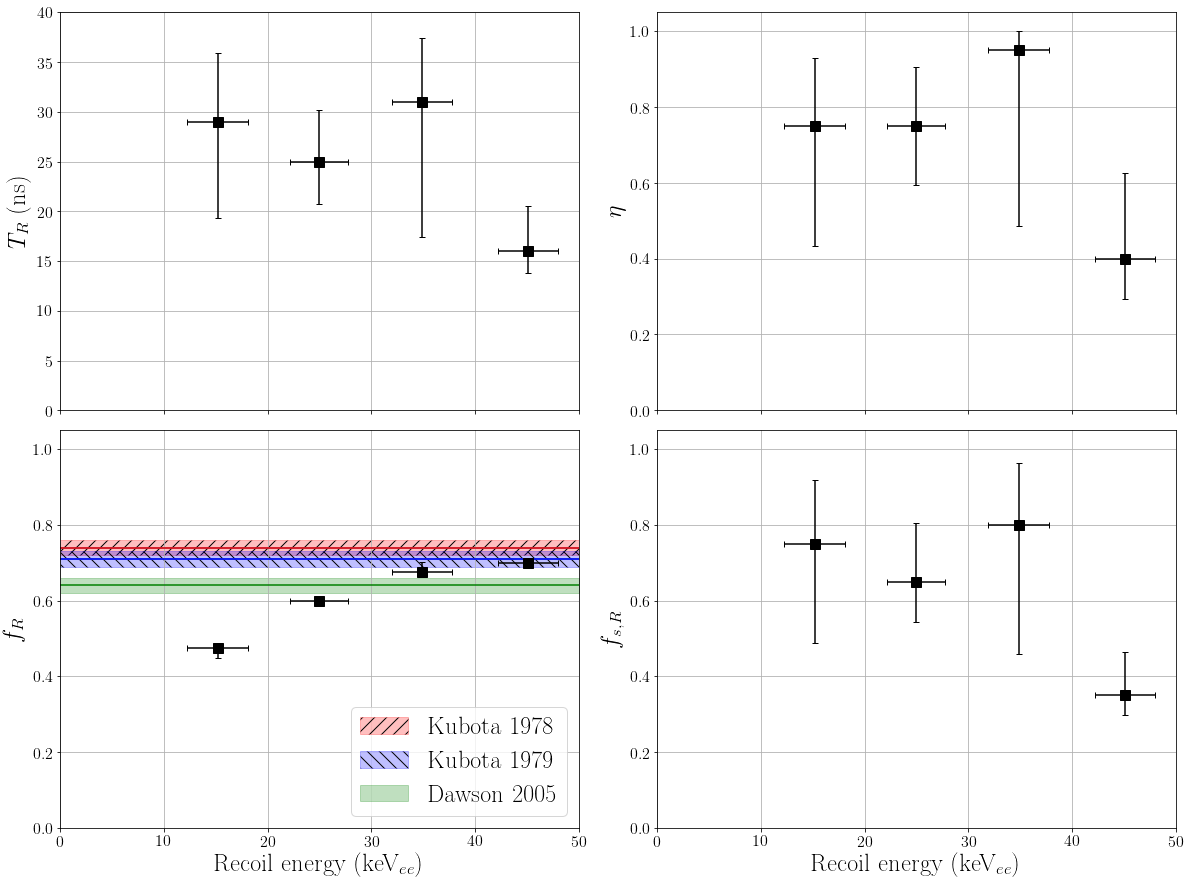

In [54]:
ms = 10 # markersize
cs = 3 # capsize for the error bars

f = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(2, 2, hspace = 0.05, wspace = 0.15) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
axes = [ax0, ax1, ax2, ax3]

for ax, key in zip(axes, keys):
    ax.errorbar(x['e'], xerr = x['de'], y = x[key], yerr = ( x['d' + key + '-'], x['d' + key + '+']), 
                     marker = 's', markersize = ms, ls='None', capsize = cs, color='black')

ax0.set_ylabel(r'$T_R$ (\si{ns})')
ax1.set_ylabel(r'$\eta$')
ax2.set_ylabel(r'$f_R$')
ax3.set_ylabel(r'$f_{s, R}$')

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(0, 1.05)
    
ax0.set_ylim(0, 40)

for ax in axes:
    ax.set_xlim(0, 50)

for ax in [ax0, ax1]:
    ax.get_xaxis().set_ticklabels([])
    
for ax in axes:
    ax.grid()
    
for ax in [ax2, ax3]:
    ax.set_xlabel('Recoil energy (keV$_{ee}$)')
    
# Plots for fR
plt.sca(ax2)
plt.axhline(0.71) # kubota phys rev b 20, 8, 1979
plt.axhline(0.74)# pm 0.02 kubota et al 1978 phys rev b 17, 2762 - 2765
def plot_sigma_band(mu, sig, c, **kwargs):
    plt.axhline(mu, color=c)
    plt.fill_between((0, 50), [mu - sig, mu-sig], [mu+sig, mu+sig], color=c, **kwargs)
    
#plt.axhline(0.64) # pm 0.02 Co60 Dawson et al a study of the scintillation induced by alpha ...
plot_sigma_band(0.74, 0.02, alpha=0.25, label = 'Kubota 1978', c='red', hatch='//', edgecolor='red')
plot_sigma_band(0.71, 0.02, alpha=0.25, label = 'Kubota 1979', c='blue', hatch='\\\\') # Same error because same procedure
plot_sigma_band(0.64, 0.02, alpha=0.25, label='Dawson 2005', c = 'green')

# plt.axhline(0.71, color='blue', label='Kubota 1979')

handles, labels = ax2.get_legend_handles_labels()
# handles = [handles[2], handles[0], handles[1]]
# labels =  [labels[2], labels[0], labels[1]]

plt.legend(handles[:3], labels[:3], loc='lower right')
plt.savefig('/home/erik/win/notes/recombination_panels.pdf', bbox_inches='tight')

### Example of correlation

In [308]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [321]:
ddf = ddf_er_0_rec
df = ddf[1]

In [369]:
_x, _y, _z = parslice_2d_values(df, 'eta', 'tr')

In [370]:
_x = _x.values
_y = _y.values
_z = _z.values

(10, 37)

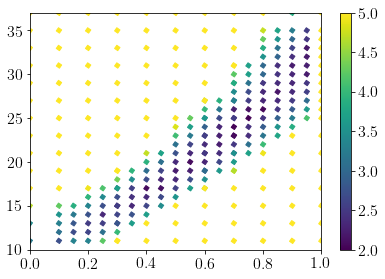

In [352]:
plt.scatter(_x, _y, c= _z, vmin = 2, vmax=5, marker=(4, 0, 10), s = 30)

# plt.scatter(_x, _y, c= _z, vmin = 2, vmax=5, marker='s', s = 140)
plt.colorbar()
plt.xlim(0, 1)
plt.ylim(10, 37)

In [379]:
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(mpl.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], facecolor='none', **kwargs))

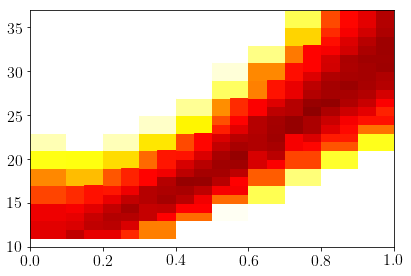

In [389]:
from matplotlib.patches import Rectangle
cmap = plt.cm.hot

ax = plt.gca()
for i in range(len(_x)):
    ax.add_patch(Rectangle(
        (_x[i], _y[i]), 0.5, 2, color=cmap(_z[i] * 1)))
plt.xlim(0, 1)
plt.ylim(10, 37)
plt.show()

In [364]:
_z.values[i]

3.2148558290114861

In [339]:
len(_z)

298

In [ ]:
_z.values.reshape()

In [343]:
np.reshape(_z, (2, 149))

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


array([[   3.21485583,    3.42236278,    4.68416843,    5.6798519 ,
           7.64809241,    9.21888226,   11.37381706,   13.73660691,
          15.20983805,   16.99024953,   19.14816291,   20.70851066,
          23.31775648,   24.48154781,    2.73423698,    3.11791994,
           3.29381641,    3.54930207,    4.27306175,    6.45944785,
           7.58380756,   10.07638197,   11.4323693 ,   14.20677889,
          15.25573406,   18.67402175,   20.65661596,   21.85637713,
          23.48169798,   25.41664875,    3.31812417,    2.70271019,
           2.81428143,    3.21027462,    3.87857843,    3.31717393,
           2.62071898,    2.53382452,    2.76271904,    3.35605533,
           3.95263516,    4.93678885,    6.93492274,    9.27426037,
          11.07191865,   13.28812433,   15.58312508,   18.63397408,
          20.08837536,   20.79211774,   23.25889662,   25.504011  ,
           4.2339573 ,    3.10811721,    2.55270194,    2.33584117,
           2.73688884,    3.41515405,    4.15569

In [341]:
plt.imshow(np.reshape(_z, 4))

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


ValueError: total size of new array must be unchanged

## Fit example

This requires the four-fit data to have been read, and the ddf from `Read all four-fit data` 

In [37]:
df = ddf_er[2]

In [38]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [39]:
import matplotlib as mpl
def fancyplot(**params):
    gridalpha = 0.3
    
    params = get_params(params)
    sigmas = get_sigma(**params)
    model = params['model']
    ydata = params['ydata']
    scale = 1/np.max(ydata)

    # large subplot
    ax2 = plt.subplot2grid((3,1), (2,0))
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

    plt.sca(ax1)
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    leg = plt.legend(loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    leg.legendHandles[1]._legmarker.set_markersize(8)
    plt.ylim(0, None)
    plt.title(r'\bf{Electronic recoil, %d - %d keV}' % (params['e_min'], params['e_max']))
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(prune='lower'))
    
    # Add residuals
    plt.sca(ax2)
    plt.subplot2grid((3,1), (2,0), sharex=ax1)
#     plt.xlim(-12, 150)
#     for _l in (params['t_min'], params['t_max']):
#         plt.axvline(_l)
    plt.xlim(params['t_min'], params['t_max'])

    res = (ydata - model) / sigmas # residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res, marker='x', ls='None', c='k', markersize=5)
    plt.plot(spe_ts, res, ls='--', c='k', alpha = 0.5)

    plt.grid(which='both', linestyle='-', alpha=gridalpha)
    plt.axhline(0, c='k', alpha=0.5)
    plt.ylim(-3, 3)
    for pol in [+1, -1]:
        plt.axhline(pol * 1, ls='--', color='k', alpha=0.25)
        plt.axhline(pol * 2, ls='solid', color='k', alpha=0.25)

    plt.ylabel("Residual")
    plt.xlabel("Time (ns)")
    plt.gcf().subplots_adjust(0,0,1,1,0,0)
    ax1.get_yaxis().set_label_coords(-0.067 ,0.5)
    # ax2.get_yaxis().set_label_coords(0, 0.5)
    


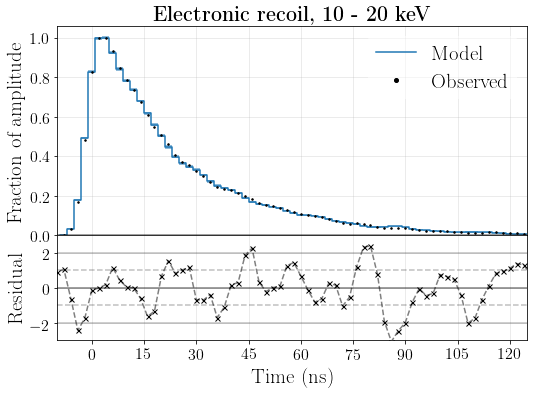

In [40]:
fancyplot(**minvalue(df, to_input=True))
plt.savefig('pulsefit.pdf', bbox_inches='tight')

In [43]:
def fancylong(**params):
    gridalpha = 0.3
    h_bottom = 0.15
    h_top = (0.8 - h_bottom)/2

    params = get_params(params)
    sigmas = get_sigma(**params)
    model = params['model']
    ydata = params['ydata']
    scale = 1/np.max(ydata)
    xlim = (params['t_min'], params['t_max'])

    plt.figure(figsize = (6.531496194824962, 2* 4.3543307965499745)) # Double height figure
    
    #### FRAME 1
    frame1=plt.gcf().add_axes((.1,0.1 + h_top + h_bottom,.8, h_top))
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid', label='Uncertainty')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')
    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(frame1.get_xticklabels(), visible=False)
    plt.axhline(0, c='k', alpha=0.5)
    handles, labels =  frame1.get_legend_handles_labels()
    labels = [labels[0], labels[2], labels[1]]
    handles = [handles[0], handles[2],handles[1]]
    leg = plt.legend(handles, labels, loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    leg.legendHandles[2]._legmarker.set_markersize(8)
    plt.ylim(0, 1.1)
    plt.title(r'\bf{Electronic recoil, %d - %d keV$_{ee}$}' % (params['e_min'], params['e_max']))
    plt.yticks(np.arange(0.2, 1.2, 0.2))

    plt.xlim(xlim)
    #### FRAME 2
    frame2=plt.gcf().add_axes((.1,0.1 + h_bottom,.8, h_top))
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(frame2.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    plt.yscale('log')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(prune='lower'))
    plt.xlim(xlim)
    plt.xticks(np.arange(0, 140, 20))
    plt.ylim(5e-4, 1.2)
    frame3=plt.gcf().add_axes((.1,.1,.8, h_bottom))
    res = (ydata - model) / sigmas # residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res, marker='x', ls='None', c='k', markersize=5)
    plt.plot(spe_ts, res, ls='--', c='k', alpha = 0.5)

    plt.grid(which='both', linestyle='-', alpha=gridalpha)
    plt.axhline(0, c='k', alpha=0.5)
    plt.ylim(-3, 3)
    plt.xlim(xlim)
    plt.yticks([-2, -1, 0, 1, 2])
    for pol in [+1, -1]:
        plt.axhline(pol * 1, ls='--', color='k', alpha=0.25)
        plt.axhline(pol * 2, ls='solid', color='k', alpha=0.25)

    plt.ylabel(r"$\Delta/\sigma$")
    plt.xlabel("Time (ns)")
    
    frame2.get_yaxis().set_label_coords(-0.10 , 1)
    frame3.get_yaxis().set_label_coords(-0.10 , 0.5)
    print(params['chi2'])

1.4380650642


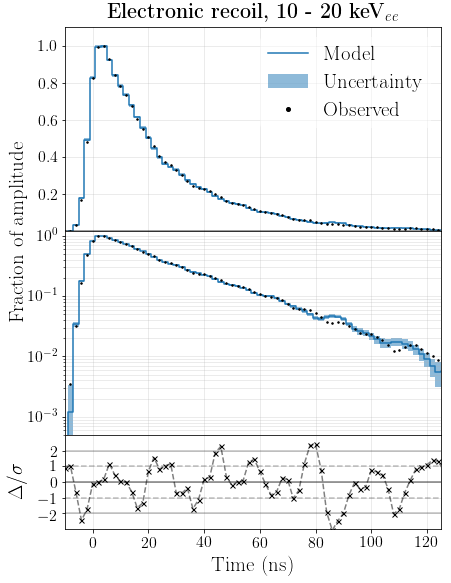

In [45]:
fancylong(**minvalue(df, to_input=True))
plt.savefig('/home/erik/win/notes/fig7.pdf', bbox_inches='tight')

In [46]:
minvalue(df, to_input=False)

{'chi2': 1.4380650642000314,
 'dset': 'er',
 'e_max': 20,
 'e_min': 10,
 'fs': 0.17999999999999999,
 'n_photons': 1000000,
 'stored_stat': True,
 't1': 2.75,
 't3': 25.0,
 'tts': 1.5}

## Chi2 evolution

In [106]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


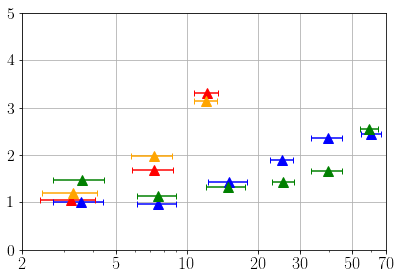

In [114]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks = [2, 5, 10, 20, 30, 50, 70]

for x, l, c in zip([x_er, x_nr, x_er_l, x_nr_l], ['ER', 'NR', 'ER_l', 'NR_l'], ['blue', 'red', 'green', 'orange']):
    plt.errorbar(x['e'], x['chi2'], xerr=x['de'], # yerr=x['dchi2'],
                 label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)
    
plt.xlim(2, 70)
plt.xscale('log')
plt.xticks(xticks)
plt.gca().set_xticklabels([str(xtick) for xtick in xticks])
plt.grid()
plt.ylim(0, 5)
# plt.legend()
plt.show()

# Improvements (R&D section)

## Interpretation of chi2 thing

In [450]:
ndf = 20
offset = 2.5
sigma = 2

def get_chi2(ndf, sigma, f_real, preal, f_fit, x0, xreal, plot=False, ret = 'ratio'):    
    t       = np.linspace(0, 100, ndf)
    err_est = np.ones(ndf) * sigma
    y = f_real(t, **preal)
    dy = np.random.normal(loc=0, scale=sigma, size=ndf)
    y = y + dy
    
    if plot:
        plt.plot(t, y)
    truefit = np.sum(((y - f_fit(t, xreal)) / err_est)**2) / ndf
    if ret == 'truevalue':
        return truefit
    
    optres = scipy.optimize.minimize(lambda x : np.sum(((y - f_fit(t, x)) / err_est)**2) / ndf, x0).fun
    return truefit / optres


In [387]:
(126 + 2) /2

64.0

In [388]:
def const(x, a):
    return a

In [413]:
get_chi2(64, 1, const, {'a':1}, const, 2)

2.2002291566520271

In [435]:
chi2s = [get_chi2(64, 1, const, {'a':1}, const, 2, 1) for _ in range(10000)]

Cutoff at 1.015860


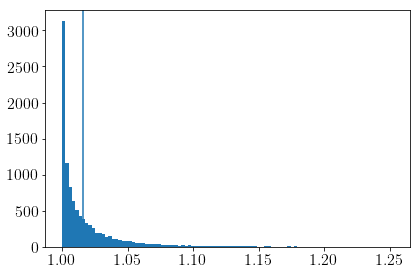

In [436]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [454]:
chi2s = [get_chi2(6, 1, const, {'a':1}, const, 2, 1) for _ in range(10000)]

Cutoff at 1.241256


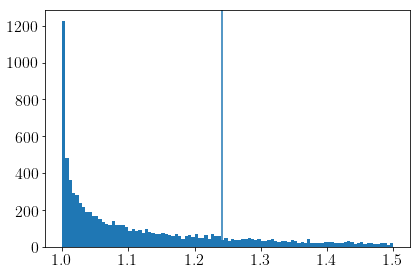

In [456]:
plt.hist(chi2s, bins=100, range=(1, 1.5))
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [422]:
def const_w_osc(x, a, period, amp):
    return a + amp * np.cos(2 * np.pi * x/period)

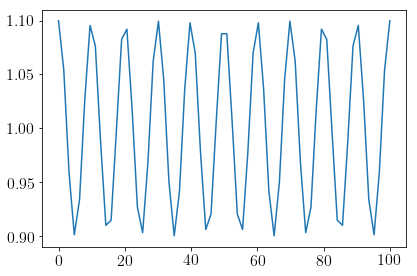

In [423]:
t = np.linspace(0, 100, 64)
plt.plot(t, const_w_osc(t, 1, 10, 0.1))

1.0000372882850095

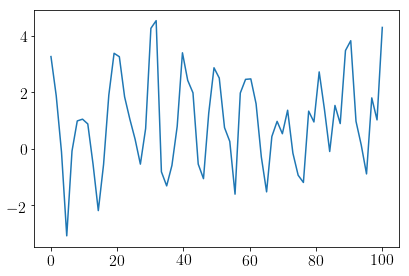

In [443]:
get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1, plot=True)

In [437]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=0.1), const, 2, 1) for _ in range(10000)]

Cutoff at 1.015604


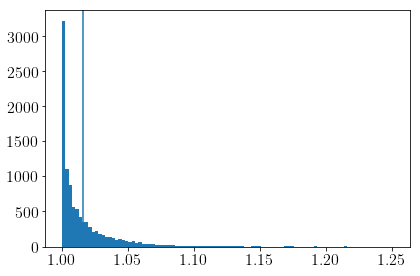

In [438]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [457]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=1.), const, 2, 1) for _ in range(10000)]

Cutoff at 1.010703


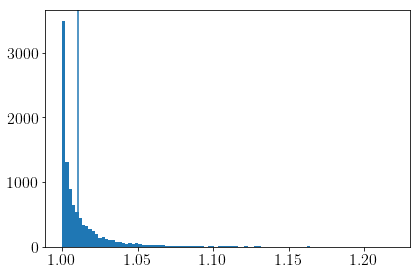

In [458]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [444]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1) for _ in range(10000)]

Cutoff at 1.005576


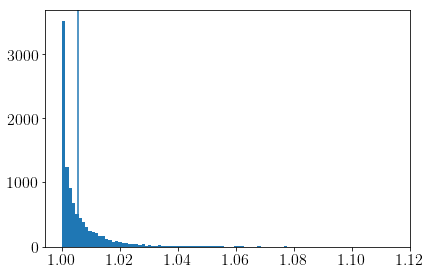

In [445]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [451]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1, ret='truevalue') for _ in range(10000)]

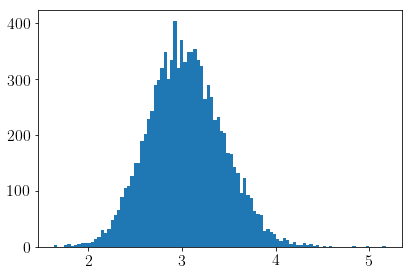

In [453]:
plt.hist(chi2s, bins=100)
plt.show()